# Drum and Ebony Skin Bleaching Ads

This is a data analysis of skin bleaching ads from Ebony and Drum magazines over several decades. The data was collected by hand and captures several aspects of the ads, including the product, the active ingredient, the claims made, as well as the catch phrases used.

## Table of Contents

* [Data Structure](data)
* [Most Frequent Words](#mfw)
* [Ngrams]()

In [1]:
__author__ = "Aaron Mauro"
__role__ = "researcher"
__institution__ = "Brock University"
__email__ = "amauro@brocku.ca"
__status__ = "prototype/experiment"
__version__ = "0.1"

In [53]:
# Imports

import os
import sys
import csv
import string
import nltk
import gensim
import pprint as pp
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import networkx as nx

# direct imports
from gensim import corpora, models
from sklearn.manifold import TSNE
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from IPython.display import SVG, display

# REMOVE IN PROD
import pygal
#pd.set_option('display.mpl_style', 'default')

In [122]:
help(plt.figaspect)

Help on function figaspect in module matplotlib.figure:

figaspect(arg)
    Calculate the width and height for a figure with a specified aspect ratio.
    
    While the height is taken from :rc:`figure.figsize`, the width is
    adjusted to match the desired aspect ratio. Additionally, it is ensured
    that the width is in the range [4., 16.] and the height is in the range
    [2., 16.]. If necessary, the default height is adjusted to ensure this.
    
    Parameters
    ----------
    arg : float or 2d array
        If a float, this defines the aspect ratio (i.e. the ratio height /
        width).
        In case of an array the aspect ratio is number of rows / number of
        columns, so that the array could be fitted in the figure undistorted.
    
    Returns
    -------
    width, height
        The figure size in inches.
    
    Notes
    -----
    If you want to create an axes within the figure, that still preserves the
    aspect ratio, be sure to create it with equal widt

In [126]:
# Select Matplotlib style
plt.matplotlib.style.use("fivethirtyeight")
plt.figure(figsize=(30, 20))

<Figure size 2160x1440 with 0 Axes>

<Figure size 2160x1440 with 0 Axes>

In [5]:
# English stopwords
STOPS = stopwords.words('english')
print(STOPS)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [6]:
# Add additional stops
new_stops = ["I",] # add new stops here
for stop in new_stops:
    STOPS.append(stop)

## Data Structure and Sample Contents
<a class="anchor" id="data"></a>

In [7]:
# Create dataframe from Ebony skin bleaching adds from 1960-1990

ebony = pd.read_csv("Ebony.skin.ads.1960-1990.csv", parse_dates=True, index_col='Year')
ebony.head() # show first five rows of dataframe
#ebony.tail() # show last five rows of dataframe

,Region,Source,Product name,chemical/active ingredient,Structure,Chemistry,Claims,Legal issues and Politics,Race,Age,Advertising strategy *quotes-catch phrase*,Size of Advert,Pg reference (quentin marked),Notes
Year,,,,,,,,,,,,,,
1960-01-01,NaN,Ebony,Long Aid Bleach and Glow,unnamed,NaN,NaN,""" - wakes up dark, dull complexion! Conceals u...",NaN,NaN,NaN,NaN,1/2 pg,63,small part of 1.2 pg ad for Long Aid hair prod...
1960-01-01,NaN,NaN,Mercolized Wax Cream,ammoniated mercury; zinc oxide,NaN,NaN,"""If your skin doesn't look actually lighter af...",NaN,NaN,NaN,"""Mercolized Wax Cream guarantees lighter looki...",1/4 pg,72,ingredient on image of product; not mentioned ...
1960-01-01,NaN,NaN,Black and White Bleaching Cream,unnamed,NaN,NaN,"""And you, too, can have a glamorous complexion...",NaN,NaN,NaN,"""Lighter, brighter skin is irresistable""",1/8 pg,83,drawing of white man and white woman in ad
1960-01-01,NaN,NaN,Nadinola Bleaching Cream,"""wonder-working A-M""",NaN,NaN,"""Don't let dull, dark skin rob you of romance....",NaN,NaN,NaN,"""LIFE IS MORE FUN when your complexion is clea...",full pg,91,two types advertised - oily and dry skin
1960-01-01,NaN,NaN,Dr. Fred Palmer's Double Strength Skin Whitener,zinc phenolsulfonate,NaN,NaN,"""Yes in just 7 days be delighted how fast and ...",NaN,NaN,NaN,"""DR. FRED PALMER'S IN JUST 7 DAYS MUST GIVE YO...",1/8 pg,108,NaN


In [8]:
# Create dataframe from Drum skin bleaching adds from 1965-1988

drum = pd.read_csv("Drum_Skin_Lighteners_1965_1988.csv", parse_dates=True, index_col='Year')
drum.head() # show first five rows of dataframe
# drum.tail() # show last five rows of dataframe

,Product name,chemical/active ingredient,Claims,Legal issues and Politics,Race,Age,Advertising strategy *quotes-catch phrase*,Size of Advert,Pg. reference ( marked),Notes
Year,,,,,,,,,,
1965-01-01,ARTRA skin tone cream,Hydroquinone,…to make their skin lighter and lovelier…lovel...,Black model and white pharmacist/doctor,Black,20+,"Lighter, lovelier skin today…the American way!'",full pg.,pg. 2,The ad says that the cream was developed after...
1965-01-01,NaN,NaN,brightens skin.' '…lightens from the first day...,n/a,NaN,NaN,Cream your skin lighter and brighter with ama...,NaN,pg. 2,Ad states that it is a medicated beauty bar. S...
1965-01-01,NaN,NaN,immediately.' '…keeps skin beautiful and clean...,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1965-01-01,Artra beauty bar,Hydroquinone,…mild and gentle…keeps skin free from blemishe...,NaN,NaN,20+,Medicated soap for complexion care,NaN,NaN,NaN
1965-01-01,Aloma Crème blanche,unnamed,"…clears and lightens the skin, smooth's away b...",Black model,Black,20-35,good things happen to a pretty girl,full pg.,NaN,Ad states that using this product will increas...


## Preprocessing Ad Catch Phrases and Claims
As a first step in this analysis, we will capture the most frequent words (MFW) represented in both the catch phrases and claims of the ads. 

In [9]:
# Set the Ebony dataframe index to the year
years_ebony = ebony.index
years_ebony = set(years_ebony.year)

In [10]:
# Set the Drum dataframe index to the year
years_drum = drum.index
years_drum = set(years_drum.year)

In [11]:
# Grab Ebony catch phrases by year and drop rows without data
catch_phrase_ebony = ebony["Advertising strategy *quotes-catch phrase*"].dropna()

In [12]:
# Show first five rows of Ebony catch phrases
catch_phrase_ebony.head()

Year
1960-01-01    "Mercolized Wax Cream guarantees lighter looki...
1960-01-01             "Lighter, brighter skin is irresistable"
1960-01-01    "LIFE IS MORE FUN when your complexion is clea...
1960-01-01    "DR. FRED PALMER'S IN JUST 7 DAYS MUST GIVE YO...
1960-01-01    "Egyptian formula BLEACH CRÈME gives amazing r...
Name: Advertising strategy *quotes-catch phrase*, dtype: object

In [16]:
# Grab Drum catch phrases by year and drop rows without data
catch_phrase_drum = drum["Advertising strategy *quotes-catch phrase*"].dropna()

In [17]:
# Show first five rows of Ebony catch phrases
catch_phrase_drum.head()

Year
1965-01-01      Lighter, lovelier skin today…the American way!'
1965-01-01     Cream your skin lighter and brighter with ama...
1965-01-01                   Medicated soap for complexion care
1965-01-01                  good things happen to a pretty girl
1965-01-01                                            See notes
Name: Advertising strategy *quotes-catch phrase*, dtype: object

In [18]:
# Grab Drum and Ebony claims
claims_ebony = ebony["Claims"].dropna()
claims_drum = drum['Claims'].dropna()
print("Ebony claims",claims_ebony.head())
print(claims_ebony.head())

Ebony claims Year
1960-01-01    " - wakes up dark, dull complexion! Conceals u...
1960-01-01    "If your skin doesn't look actually lighter af...
1960-01-01    "And you, too, can have a glamorous complexion...
1960-01-01    "Don't let dull, dark skin rob you of romance....
1960-01-01    "Yes in just 7 days be delighted how fast and ...
Name: Claims, dtype: object
Year
1960-01-01    " - wakes up dark, dull complexion! Conceals u...
1960-01-01    "If your skin doesn't look actually lighter af...
1960-01-01    "And you, too, can have a glamorous complexion...
1960-01-01    "Don't let dull, dark skin rob you of romance....
1960-01-01    "Yes in just 7 days be delighted how fast and ...
Name: Claims, dtype: object


In [20]:
# Delete?
claims_drum_sents = []
i = 0
for claim in claims_drum:
    temp_claim = "".join([ch for ch in claim if (ch.isalpha() or ch == " ") and ch not in string.punctuation]).lower()
    claims_drum_sents.append((str(claims_drum.keys()[i]),temp_claim))
    i += 1
print(claims_drum_sents[:5])

[('1965-01-01 00:00:00', 'to make their skin lighter and lovelierlovelier and lightera little more every day american scientist made artralightens and'), ('1965-01-01 00:00:00', 'brightens skin lightens from the first day vanishes into skin instantlystarts working starts lightening and brightening your skin'), ('1965-01-01 00:00:00', 'immediately keeps skin beautiful and clean makes it smooth and lovely'), ('1965-01-01 00:00:00', 'mild and gentlekeeps skin free from blemishes and pimples'), ('1965-01-01 00:00:00', 'clears and lightens the skin smooths away blemishes and spots softens the skin')]


In [22]:
# Delete?
claims_ebony_sents = []
i = 0
for claim in claims_ebony:
    temp_claim = "".join([ch for ch in claim if (ch.isalpha() or ch == " ") and ch not in string.punctuation]).lower()
    claims_ebony_sents.append((str(claims_ebony.keys()[i]),temp_claim))
    i += 1
print(claims_ebony_sents[:5])

[('1960-01-01 00:00:00', '  wakes up dark dull complexion conceals ugly blotches blemishes while it bleaches guarantees lovelier lighter skin'), ('1960-01-01 00:00:00', 'if your skin doesnt look actually lighter after using mercolized wax cream for just one week your money will be cheerfully refunded youll see amazing results almost at once  as mercolized wax creams speedy bleaching action lightens your complexion fades dark blotches spots and freckles brings excessive skin oiliness under control works under the skin surface to bring about these marvelous results used by beautiful women for over  years'), ('1960-01-01 00:00:00', 'and you too can have a glamorous complexion see your skin get a lighter brighter softer look its bleaching action works effectively inside your skin modern science knows no faster way of lightening skin'), ('1960-01-01 00:00:00', 'dont let dull dark skin rob you of romance dont let oiliness big pores blackheads cheat you of charm this remarkable medicated ingr

## Most Frequent Words

In an effort to collect keywords for later processes, we will grab the most frequent words (MFW) and compare them to most common bigram pairs. We'll start with Drum then do the same operations for Ebony.

## Drum Magaine MFW

In [24]:
# Convert dataframe into a list of lists of sentences for Drum
drum_catch_phrase_and_claims = pd.merge(catch_phrase_drum, claims_drum, right_index=True, left_index=True).dropna()
drum_claims_phrase_list = drum_catch_phrase_and_claims.values.tolist()
drum_claims_phrase_list[:10]

[["Lighter, lovelier skin today…the American way!'",
  "…to make their skin lighter and lovelier…lovelier and lighter…a little more every day' '…American scientist made artra…lightens and"],
 ["Lighter, lovelier skin today…the American way!'",
  "brightens skin.' '…lightens from the first day.' '…vanishes into skin instantly…starts working, starts lightening and brightening your skin"],
 ["Lighter, lovelier skin today…the American way!'",
  "immediately.' '…keeps skin beautiful and clean, makes it smooth and lovely"],
 ["Lighter, lovelier skin today…the American way!'",
  '…mild and gentle…keeps skin free from blemishes and pimples'],
 ["Lighter, lovelier skin today…the American way!'",
  "…clears and lightens the skin, smooth's away blemishes and spots, softens the skin'"],
 ["Lighter, lovelier skin today…the American way!'",
  '...gets to work immediately- to give you a lighter, lovelier complexion'],
 ["Lighter, lovelier skin today…the American way!'",
  "a fair complexion, clear sk

In [25]:
# Tokenize and preprocess lists of sentences
drum_word_corpus_list = []
for ad in drum_claims_phrase_list:
    sents = [ch for ch in " ".join(ad).lower() if ch not in string.punctuation+"…"]
    drum_word_corpus_list.append("".join(sents).split())
print(drum_word_corpus_list[:5])

[['lighter', 'lovelier', 'skin', 'todaythe', 'american', 'way', 'to', 'make', 'their', 'skin', 'lighter', 'and', 'lovelierlovelier', 'and', 'lightera', 'little', 'more', 'every', 'day', 'american', 'scientist', 'made', 'artralightens', 'and'], ['lighter', 'lovelier', 'skin', 'todaythe', 'american', 'way', 'brightens', 'skin', 'lightens', 'from', 'the', 'first', 'day', 'vanishes', 'into', 'skin', 'instantlystarts', 'working', 'starts', 'lightening', 'and', 'brightening', 'your', 'skin'], ['lighter', 'lovelier', 'skin', 'todaythe', 'american', 'way', 'immediately', 'keeps', 'skin', 'beautiful', 'and', 'clean', 'makes', 'it', 'smooth', 'and', 'lovely'], ['lighter', 'lovelier', 'skin', 'todaythe', 'american', 'way', 'mild', 'and', 'gentlekeeps', 'skin', 'free', 'from', 'blemishes', 'and', 'pimples'], ['lighter', 'lovelier', 'skin', 'todaythe', 'american', 'way', 'clears', 'and', 'lightens', 'the', 'skin', 'smooths', 'away', 'blemishes', 'and', 'spots', 'softens', 'the', 'skin']]


In [26]:
# Collect all words into single sentence
drum_word_corpus = []
for sent in drum_word_corpus_list:
    for word in sent:
        drum_word_corpus.append(word)

In [33]:
# Total words in corpus and preview Drum word list 
drum_num = len(drum_word_corpus)
print(f"There are {drum_num:,} words in the Drum Magazine corpus.")
print(drum_word_corpus[:10])

There are 211,112 words in the Drum Magazine corpus.
['lighter', 'lovelier', 'skin', 'todaythe', 'american', 'way', 'to', 'make', 'their', 'skin']


In [34]:
# Create an NLTK Text object
drum_text_object = nltk.Text(drum_word_corpus)

In [35]:
# Generate a sample concordance, displaying 120 characters of 25 matches
drum_text_object.concordance("good",120,25)

Displaying 25 of 428 matches:
e sooner you startexpect a lovely clear bright complexion good things happen to a pretty girl to make their skin lighter
 more every day american scientist made artralightens and good things happen to a pretty girl brightens skin lightens fr
tarts working starts lightening and brightening your skin good things happen to a pretty girl immediately keeps skin bea
keeps skin beautiful and clean makes it smooth and lovely good things happen to a pretty girl mild and gentlekeeps skin 
mild and gentlekeeps skin free from blemishes and pimples good things happen to a pretty girl clears and lightens the sk
he skin smooths away blemishes and spots softens the skin good things happen to a pretty girl gets to work immediately t
ork immediately to give you a lighter lovelier complexion good things happen to a pretty girl a fair complexion clear sk
ish free and spot free can be obtained using this product good things happen to a pretty girl your skin will grow lighte
sh

In [59]:
# Remove stop words
drum_word_corpus_no_stops = []
for word in drum_word_corpus:
    if word not in STOPS: #add extra stops above
        drum_word_corpus_no_stops.append(word)
drum_freqs = nltk.FreqDist(drum_word_corpus_no_stops)
drum_most_common_counts = drum_freqs.most_common(75)
drum_most_common = []
for t,c in drum_most_common_counts:
    drum_most_common.append(t)
pp.pprint(drum_most_common_counts)

[('skin', 11413),
 ('complexion', 3707),
 ('light', 3321),
 ('karroo', 2997),
 ('lighter', 2685),
 ('ambi', 2671),
 ('beautiful', 2646),
 ('lovely', 2262),
 ('beauty', 2006),
 ('makes', 1950),
 ('extra', 1888),
 ('cream', 1826),
 ('use', 1804),
 ('new', 1757),
 ('look', 1701),
 ('smooth', 1669),
 ('lightening', 1650),
 ('fast', 1619),
 ('night', 1594),
 ('lightens', 1534),
 ('keeps', 1532),
 ('clear', 1363),
 ('people', 1332),
 ('smoother', 1173),
 ('pimples', 1149),
 ('spots', 1134),
 ('creams', 1090),
 ('great', 1067),
 ('hollywood', 1048),
 ('day', 992),
 ('blemishes', 977),
 ('looking', 904),
 ('successful', 884),
 ('morning', 881),
 ('dark', 859),
 ('seven', 835),
 ('miss', 805),
 ('acting', 803),
 ('ugly', 787),
 ('best', 778),
 ('lotion', 748),
 ('lighten', 741),
 ('queen', 712),
 ('men', 678),
 ('quick', 676),
 ('super', 658),
 ('lovelier', 655),
 ('time', 639),
 ('treatment', 623),
 ('face', 620),
 ('always', 614),
 ('karoo', 604),
 ('way', 599),
 ('hilite', 595),
 ('clearer',

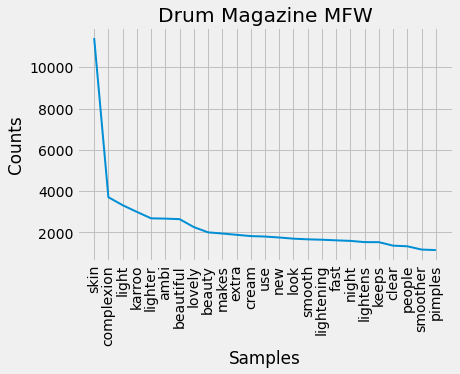

<AxesSubplot:title={'center':'Drum Magazine MFW'}, xlabel='Samples', ylabel='Counts'>

In [135]:
drum_freqs.plot(25, title="Drum Magazine MFW")

In [38]:
drum_text_object.concordance("karroo",120,25)

Displaying 25 of 2997 matches:
 sooner you startexpect a lovely clear bright complexion karroo morning karoo night keeps you lovely keeps you light to 
more every day american scientist made artralightens and karroo morning karoo night keeps you lovely keeps you light bri
arts working starts lightening and brightening your skin karroo morning karoo night keeps you lovely keeps you light imm
eeps skin beautiful and clean makes it smooth and lovely karroo morning karoo night keeps you lovely keeps you light mil
ild and gentlekeeps skin free from blemishes and pimples karroo morning karoo night keeps you lovely keeps you light cle
e skin smooths away blemishes and spots softens the skin karroo morning karoo night keeps you lovely keeps you light get
rk immediately to give you a lighter lovelier complexion karroo morning karoo night keeps you lovely keeps you light a f
sh free and spot free can be obtained using this product karroo morning karoo night keeps you lovely keeps you light you
h

## Bigram and Trigrams in Drum

In [57]:
# Collocations of commonly associated terms in Drum corpus, not necessarily bigrams
# Please see NLTK collocations documentation to understand how collocations are 
# selected: https://www.nltk.org/_modules/nltk/collocations.html

drum_text_object.collocations(num=100)

hollywood seven; karroo morning; successful people; morning karoo;
skin lightening; use ambi; beauty queen; karoo night; karroo creams;
super rose; lighter smoother; people use; lightening cream; modern
way; night makes; arms legs; cosmetic substance; miss south; americas
great; lovely makes; legs neck; always wanted; look great; ugly spots;
powerful name; lighter clearer; face arms; discolouring ugly; fast
acting; german science; extra fast; one step; spots discolouring;
removes ugly; quick acting; thoroughly removes; south africa; neck
removes; acting medicinescleans; given thousands; velvety smooth;
stronger super; double strength; light fantastic; lightening
treatment; new cosmetic; cant lose; rose heman; says miss;
complexionuse full; youll look; removes dark; quicker results; stops
production; new stronger; aviva light; heman lotion; film star; top
society; good looking; ambi youll; great looking; skin lightener;
lighten dark; ugly blemishes; americans lighter; works fast; butter

In [81]:
# Most common bigram frequencies
drum_bigram_list = list(nltk.bigrams(drum_text_object))
drum_bigram_freqs = nltk.FreqDist(drum_bigram_list)
pp.pprint(drum_bigram_freqs.most_common(75))

[(('your', 'skin'), 2664),
 (('makes', 'you'), 1373),
 (('skin', 'lightening'), 1323),
 (('you', 'lovely'), 900),
 (('use', 'ambi'), 896),
 (('you', 'light'), 887),
 (('karroo', 'morning'), 881),
 (('hollywood', 'seven'), 807),
 (('karroo', 'creams'), 741),
 (('successful', 'people'), 684),
 (('a', 'lighter'), 674),
 (('lighter', 'smoother'), 634),
 (('beauty', 'queen'), 627),
 (('lightening', 'cream'), 621),
 (('beautiful', 'skin'), 620),
 (('night', 'makes'), 616),
 (('lovely', 'makes'), 616),
 (('spots', 'and'), 610),
 (('people', 'use'), 590),
 (('pimples', 'and'), 590),
 (('morning', 'karoo'), 564),
 (('karoo', 'night'), 564),
 (('can', 'have'), 563),
 (('for', 'a'), 555),
 (('in', 'the'), 535),
 (('keeps', 'you'), 530),
 (('smooth', 'and'), 513),
 (('the', 'best'), 500),
 (('and', 'pimples'), 484),
 (('extra', 'fast'), 480),
 (('look', 'great'), 476),
 (('while', 'it'), 465),
 (('keeps', 'skin'), 437),
 (('more', 'beautiful'), 426),
 (('light', 'skin'), 419),
 (('super', 'rose'),

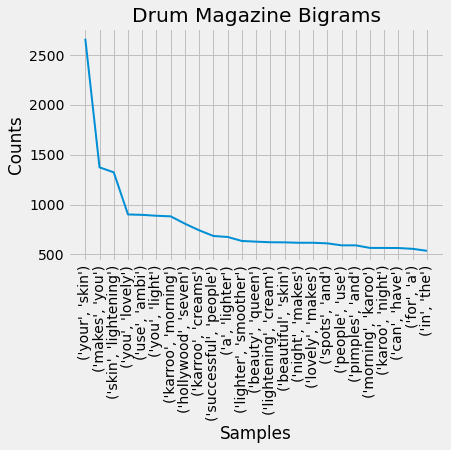

<AxesSubplot:title={'center':'Drum Magazine Bigrams'}, xlabel='Samples', ylabel='Counts'>

In [97]:
drum_bigram_freqs.plot(25, title="Drum Magazine Bigrams")

In [82]:
# Drum trigram frequencies
drum_trigram_list = list(nltk.trigrams(drum_text_object))
drum_trigram_freqs = nltk.FreqDist(drum_trigram_list)
pp.pprint(drum_trigram_freqs.most_common(75))

[(('night', 'makes', 'you'), 616),
 (('makes', 'you', 'lovely'), 616),
 (('you', 'lovely', 'makes'), 616),
 (('lovely', 'makes', 'you'), 616),
 (('makes', 'you', 'light'), 616),
 (('karroo', 'morning', 'karoo'), 564),
 (('morning', 'karoo', 'night'), 564),
 (('skin', 'lightening', 'cream'), 544),
 (('successful', 'people', 'use'), 427),
 (('spots', 'and', 'pimples'), 425),
 (('people', 'use', 'ambi'), 393),
 (('while', 'it', 'lightens'), 385),
 (('ugly', 'spots', 'and'), 375),
 (('the', 'modern', 'way'), 349),
 (('lighten', 'your', 'skin'), 340),
 (('you', 'can', 'have'), 339),
 (('now', 'you', 'can'), 335),
 (('your', 'skin', 'the'), 330),
 (('karroo', 'morning', 'karroo'), 317),
 (('morning', 'karroo', 'at'), 317),
 (('karroo', 'at', 'night'), 317),
 (('at', 'night', 'makes'), 317),
 (('skin', 'lightening', 'treatment'), 314),
 (('pimples', 'and', 'blemishes'), 313),
 (('a', 'beauty', 'queen'), 301),
 (('for', 'a', 'lighter'), 300),
 (('karoo', 'night', 'makes'), 299),
 (('lovely', '

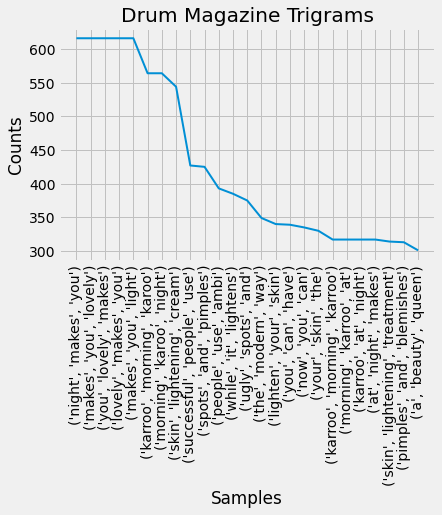

<AxesSubplot:title={'center':'Drum Magazine Trigrams'}, xlabel='Samples', ylabel='Counts'>

In [98]:
drum_trigram_freqs.plot(25, title="Drum Magazine Trigrams")

In [83]:
drum_quadgram_list = list(nltk.ngrams(drum_text_object, 4))
drum_quadgram_freqs = nltk.FreqDist(drum_quadgram_list)
pp.pprint(drum_quadgram_freqs.most_common(75))

[(('night', 'makes', 'you', 'lovely'), 616),
 (('makes', 'you', 'lovely', 'makes'), 616),
 (('you', 'lovely', 'makes', 'you'), 616),
 (('lovely', 'makes', 'you', 'light'), 616),
 (('karroo', 'morning', 'karoo', 'night'), 564),
 (('successful', 'people', 'use', 'ambi'), 393),
 (('ugly', 'spots', 'and', 'pimples'), 323),
 (('karroo', 'morning', 'karroo', 'at'), 317),
 (('morning', 'karroo', 'at', 'night'), 317),
 (('karroo', 'at', 'night', 'makes'), 317),
 (('at', 'night', 'makes', 'you'), 317),
 (('morning', 'karoo', 'night', 'makes'), 299),
 (('karoo', 'night', 'makes', 'you'), 299),
 (('your', 'skin', 'the', 'modern'), 285),
 (('skin', 'the', 'modern', 'way'), 285),
 (('white', 'skin', 'whitens', 'your'), 273),
 (('skin', 'whitens', 'your', 'skin'), 273),
 (('whitens', 'your', 'skin', 'now'), 273),
 (('your', 'skin', 'now', 'you'), 273),
 (('skin', 'now', 'you', 'can'), 273),
 (('now', 'you', 'can', 'have'), 273),
 (('you', 'can', 'have', 'the'), 273),
 (('can', 'have', 'the', 'beauti

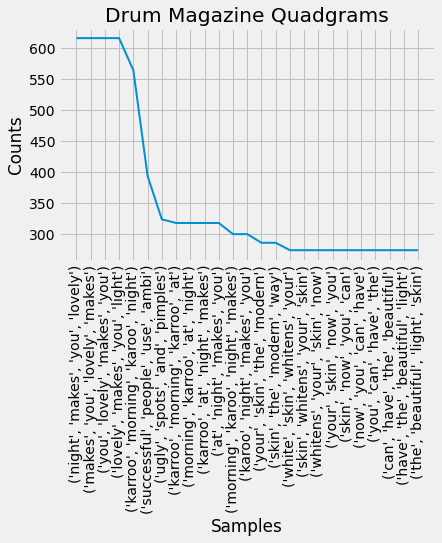

<AxesSubplot:title={'center':'Drum Magazine Quadgrams'}, xlabel='Samples', ylabel='Counts'>

In [99]:
drum_quadgram_freqs.plot(25, title="Drum Magazine Quadgrams")

## Ebony Magazine MFW 

In [102]:
# Convert dataframe into a list of lists of sentences for Ebony
ebony_catch_phrase_and_claims = pd.merge(catch_phrase_ebony, claims_ebony, right_index=True, left_index=True).dropna()
ebony_claims_phrase_list = ebony_catch_phrase_and_claims.values.tolist()
ebony_claims_phrase_list[:10]

[['"Mercolized Wax Cream guarantees lighter looking skin in just 7 days or money back!"',
  '" - wakes up dark, dull complexion! Conceals ugly blotches, blemishes while it bleaches. Guarantees lovelier, lighter skin."'],
 ['"Mercolized Wax Cream guarantees lighter looking skin in just 7 days or money back!"',
  '"If your skin doesn\'t look actually lighter after using Mercolized Wax Cream for just one week, your money will be cheerfully refunded."; "You\'ll see amazing results almost at once - as Mercolized Wax Cream\'s speedy bleaching action lightens your complexion, fades dark blotches, spots, and freckles, brings excessive skin oiliness under control."; "...works under the skin surface to bring about these marvelous results."; "Used by beautiful women for over 40 years."'],
 ['"Mercolized Wax Cream guarantees lighter looking skin in just 7 days or money back!"',
  '"And you, too, can have a glamorous complexion!"; "…see your skin get a lighter, brighter, softer look."; "Its bleachi

In [104]:
# Tokenize and preprocess lists of sentences
ebony_word_corpus_list = []
for ad in ebony_claims_phrase_list:
    sents = [ch for ch in " ".join(ad).lower() if ch not in string.punctuation+"…"]
    ebony_word_corpus_list.append("".join(sents).split())
print(ebony_word_corpus_list[:5])            

[['mercolized', 'wax', 'cream', 'guarantees', 'lighter', 'looking', 'skin', 'in', 'just', '7', 'days', 'or', 'money', 'back', 'wakes', 'up', 'dark', 'dull', 'complexion', 'conceals', 'ugly', 'blotches', 'blemishes', 'while', 'it', 'bleaches', 'guarantees', 'lovelier', 'lighter', 'skin'], ['mercolized', 'wax', 'cream', 'guarantees', 'lighter', 'looking', 'skin', 'in', 'just', '7', 'days', 'or', 'money', 'back', 'if', 'your', 'skin', 'doesnt', 'look', 'actually', 'lighter', 'after', 'using', 'mercolized', 'wax', 'cream', 'for', 'just', 'one', 'week', 'your', 'money', 'will', 'be', 'cheerfully', 'refunded', 'youll', 'see', 'amazing', 'results', 'almost', 'at', 'once', 'as', 'mercolized', 'wax', 'creams', 'speedy', 'bleaching', 'action', 'lightens', 'your', 'complexion', 'fades', 'dark', 'blotches', 'spots', 'and', 'freckles', 'brings', 'excessive', 'skin', 'oiliness', 'under', 'control', 'works', 'under', 'the', 'skin', 'surface', 'to', 'bring', 'about', 'these', 'marvelous', 'results', '

In [105]:
# Collect all words into single sentence
ebony_word_corpus = []
for sent in ebony_word_corpus_list:
    for word in sent:
        ebony_word_corpus.append(word)

In [107]:
# Total words in corpus and preview Drum word list 
ebony_num = len(ebony_word_corpus)
print(f"There are {ebony_num:,} words in the Ebony Magazine corpus. Remember, Drum Magazine contained {drum_num:,} words.")
print(ebony_word_corpus[:10])

There are 632,675 words in the Ebony Magazine corpus. Remember, Drum Magazine contained 211,112 words.
['mercolized', 'wax', 'cream', 'guarantees', 'lighter', 'looking', 'skin', 'in', 'just', '7']


In [108]:
# Create an NLTK Text object
ebony_text_object = nltk.Text(ebony_word_corpus)

In [109]:
# Generate a sample concordance, displaying 120 characters of 25 matches
ebony_text_object.concordance("good",120,25)

Displaying 25 of 205 matches:
ghten glorify skin or money back i am excited about a new good looks cream for the whole family with gentle laboratory t
 radiance of that artra look now i am excited about a new good looks cream for the whole family that velvetysoft radiant
ient proven safe for normal skin i am excited about a new good looks cream for the whole family now at last a complexion
 thats lighter brighter lovelier i am excited about a new good looks cream for the whole family long for the radiant glo
skin artra softens your skin too i am excited about a new good looks cream for the whole family no more messy oldfashion
leaching ingredient hydroquinone i am excited about a new good looks cream for the whole family clothes do the most for 
of no faster way to lighten skin i am excited about a new good looks cream for the whole family photo caption now one ac
learer smooth and radiantly soft i am excited about a new good looks cream for the whole family a delightful white cream
ig

In [110]:
# Remove stop words
ebony_word_corpus_no_stops = []
for word in ebony_word_corpus:
    if word not in STOPS: #add extra stops above
        ebony_word_corpus_no_stops.append(word)
ebony_freqs = nltk.FreqDist(ebony_word_corpus_no_stops)
ebony_most_common_counts = ebony_freqs.most_common(75)
ebony_most_common = []
for t,c in ebony_most_common_counts:
    ebony_most_common.append(t)
pp.pprint(ebony_most_common_counts)

[('skin', 26920),
 ('cream', 8765),
 ('complexion', 5046),
 ('lighter', 4923),
 ('new', 4350),
 ('beauty', 4060),
 ('nadinola', 3785),
 ('dark', 3515),
 ('artra', 3448),
 ('use', 3307),
 ('look', 3242),
 ('glow', 3139),
 ('spots', 2922),
 ('brighter', 2896),
 ('tone', 2557),
 ('blackheads', 2432),
 ('bleach', 2402),
 ('bleaching', 2395),
 ('face', 2375),
 ('see', 2321),
 ('helps', 2309),
 ('clear', 2255),
 ('lovelier', 2177),
 ('blemishes', 2135),
 ('works', 2080),
 ('contains', 1974),
 ('smooth', 1908),
 ('even', 1835),
 ('action', 1767),
 ('away', 1757),
 ('effective', 1744),
 ('treatment', 1733),
 ('ultra', 1673),
 ('ingredient', 1667),
 ('smoother', 1655),
 ('clearer', 1645),
 ('pores', 1642),
 ('women', 1590),
 ('fade', 1578),
 ('formula', 1508),
 ('try', 1501),
 ('beautiful', 1497),
 ('esoterica', 1492),
 ('care', 1491),
 ('ambi', 1475),
 ('one', 1461),
 ('soft', 1424),
 ('help', 1404),
 ('results', 1336),
 ('hydroquinone', 1321),
 ('day', 1321),
 ('surface', 1317),
 ('special', 

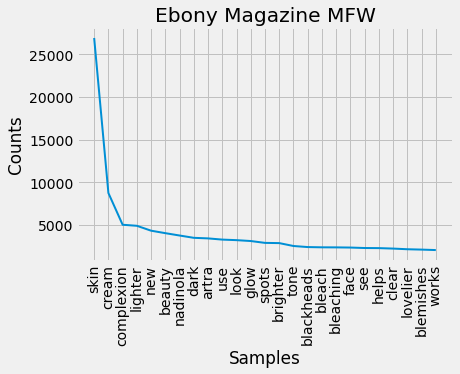

<AxesSubplot:title={'center':'Ebony Magazine MFW'}, xlabel='Samples', ylabel='Counts'>

In [111]:
ebony_freqs.plot(25, title="Ebony Magazine MFW")

In [112]:
ebony_text_object.concordance("nadinola",120,25)

Displaying 25 of 3785 matches:
in biggest beauty value you ever saw family size jar of nadinola deluxe bleaching cream a big 2 jar that contains enough
lexion make you look lots older than you really are try nadinola bleaching cream and see your skin become brighter light
m this remarkable complexionclearing ingredient enables nadinola deluxe to penetrate the skin cells to work within the s
tive by thousands of satisfied users family size jar of nadinola deluxe bleaching cream a big 2 jar that contains enough
lexion make you look lots older than you really are try nadinola bleaching cream and see your skin become brighter light
m this remarkable complexionclearing ingredient enables nadinola deluxe to penetrate the skin cells to work within the s
nd glow the look of total loveliness family size jar of nadinola deluxe bleaching cream a big 2 jar that contains enough
lexion make you look lots older than you really are try nadinola bleaching cream and see your skin become brighter light
m

## Bigram and Trigrams in Ebony

In [113]:
# Collocations of commonly associated terms in Ebony corpus, not necessarily bigrams
# Please see NLTK collocations documentation to understand how collocations are 
# selected: https://www.nltk.org/_modules/nltk/collocations.html

ebony_text_object.collocations(num=100)

lighter brighter; mercolized wax; bleaching cream; skin tone; fred
palmers; money back; enlarged pores; ultra nadinola; ammoniated
mercury; dark spots; tone cream; nadinola deluxe; modern science;
basenot greasyvanishes; greasyvanishes immediatelyfor; externally
caused; laboratories inc; inc trademark; drake laboratories; dont let;
million times; powder basenot; smootha powder; peeling treatment;
times everyone; white bleaching; persulan proved; wax cream;
repeatedly prescribed; start using; everyone knows; skin whitener;
makeup base; bleaching action; exclusive formula; palmers skin;
ingredients repeatedly; refining enlarged; ponds vanishing;
hydroquinone compounds; stabilized hydroquinone; brown spots; eye
shadows; dry blotchy; young people; helps keep; razor bumps; gplus
action; persu persu; care enough; vanishing cream; large pores;
cheerfully refunded; bright nadinolalight; peelerpak treatment; dull
dark; medicated ingredient; use persulan; highly recommended;
consecutive nights; 

In [115]:
# Most common bigram frequencies
ebony_bigram_list = list(nltk.bigrams(ebony_text_object))
ebony_bigram_freqs = nltk.FreqDist(ebony_bigram_list)
pp.pprint(ebony_bigram_freqs.most_common(75))

[(('your', 'skin'), 6006),
 (('lighter', 'brighter'), 1916),
 (('skin', 'tone'), 1881),
 (('bleach', 'and'), 1735),
 (('and', 'glow'), 1616),
 (('bleaching', 'cream'), 1416),
 (('a', 'lighter'), 1210),
 (('tone', 'cream'), 1185),
 (('your', 'complexion'), 1160),
 (('the', 'skin'), 1123),
 (('blackheads', 'and'), 1034),
 (('dark', 'spots'), 1012),
 (('mercolized', 'wax'), 996),
 (('will', 'be'), 996),
 (('of', 'your'), 962),
 (('palmers', 'skin'), 941),
 (('your', 'face'), 932),
 (('spots', 'and'), 919),
 (('ultra', 'nadinola'), 914),
 (('as', 'a'), 859),
 (('skin', 'whitener'), 853),
 (('artra', 'skin'), 825),
 (('for', 'a'), 810),
 (('to', 'use'), 798),
 (('glow', 'cream'), 780),
 (('black', 'and'), 775),
 (('and', 'white'), 775),
 (('wax', 'cream'), 771),
 (('in', 'the'), 771),
 (('skin', 'to'), 764),
 (('skin', 'beauty'), 761),
 (('nadinola', 'deluxe'), 751),
 (('can', 'be'), 741),
 (('as', 'it'), 722),
 (('brighter', 'skin'), 721),
 (('dr', 'fred'), 689),
 (('on', 'the'), 681),
 ((

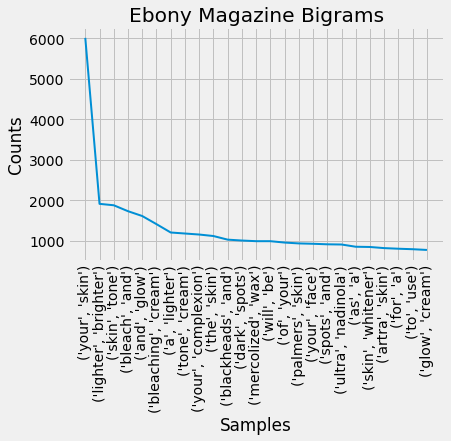

<AxesSubplot:title={'center':'Ebony Magazine Bigrams'}, xlabel='Samples', ylabel='Counts'>

In [116]:
ebony_bigram_freqs.plot(25, title="Ebony Magazine Bigrams")

In [117]:
# Ebony trigram frequencies
ebony_trigram_list = list(nltk.trigrams(ebony_text_object))
ebony_trigram_freqs = nltk.FreqDist(ebony_trigram_list)
pp.pprint(ebony_trigram_freqs.most_common(75))

[(('bleach', 'and', 'glow'), 1583),
 (('skin', 'tone', 'cream'), 1118),
 (('black', 'and', 'white'), 775),
 (('mercolized', 'wax', 'cream'), 771),
 (('and', 'glow', 'cream'), 741),
 (('artra', 'skin', 'tone'), 726),
 (('over', '40', 'years'), 674),
 (('dr', 'fred', 'palmers'), 665),
 (('lighter', 'brighter', 'skin'), 645),
 (('and', 'white', 'bleaching'), 623),
 (('white', 'bleaching', 'cream'), 610),
 (('palmers', 'skin', 'whitener'), 573),
 (('fred', 'palmers', 'skin'), 552),
 (('for', 'over', '40'), 536),
 (('a', 'lighter', 'brighter'), 516),
 (('contains', 'the', 'new'), 511),
 (('to', 'use', 'the'), 478),
 (('helps', 'keep', 'skin'), 473),
 (('nadinola', 'bleaching', 'cream'), 461),
 (('and', 'see', 'your'), 425),
 (('by', 'doctors', 'for'), 422),
 (('bleaching', 'cream', 'as'), 421),
 (('cream', 'as', 'directed'), 421),
 (('for', 'normal', 'skin'), 421),
 (('skin', 'soft', 'and'), 414),
 (('bleaching', 'action', 'works'), 411),
 (('dry', 'blotchy', 'skin'), 400),
 (('the', 'world

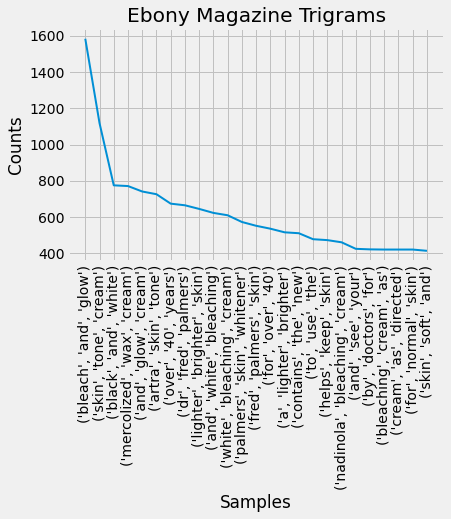

<AxesSubplot:title={'center':'Ebony Magazine Trigrams'}, xlabel='Samples', ylabel='Counts'>

In [118]:
ebony_trigram_freqs.plot(25, title="Ebony Magazine Trigrams")

In [119]:
ebony_quadgram_list = list(nltk.ngrams(ebony_text_object, 4))
ebony_quadgram_freqs = nltk.FreqDist(ebony_quadgram_list)
pp.pprint(ebony_quadgram_freqs.most_common(75))

[(('artra', 'skin', 'tone', 'cream'), 726),
 (('bleach', 'and', 'glow', 'cream'), 710),
 (('black', 'and', 'white', 'bleaching'), 623),
 (('and', 'white', 'bleaching', 'cream'), 610),
 (('dr', 'fred', 'palmers', 'skin'), 552),
 (('fred', 'palmers', 'skin', 'whitener'), 544),
 (('for', 'over', '40', 'years'), 536),
 (('white', 'bleaching', 'cream', 'as'), 421),
 (('bleaching', 'cream', 'as', 'directed'), 421),
 (('easy', 'and', 'pleasant', 'to'), 382),
 (('use', 'persulan', 'proved', 'more'), 375),
 (('persulan', 'proved', 'more', 'than'), 375),
 (('proved', 'more', 'than', '20'), 375),
 (('more', 'than', '20', 'million'), 375),
 (('than', '20', 'million', 'times'), 375),
 (('20', 'million', 'times', 'everyone'), 375),
 (('million', 'times', 'everyone', 'knows'), 375),
 (('times', 'everyone', 'knows', 'you'), 375),
 (('everyone', 'knows', 'you', 'care'), 375),
 (('knows', 'you', 'care', 'enough'), 375),
 (('you', 'care', 'enough', 'to'), 375),
 (('care', 'enough', 'to', 'use'), 375),
 (

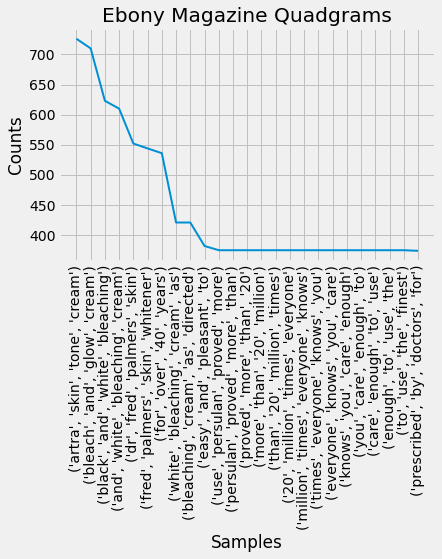

<AxesSubplot:title={'center':'Ebony Magazine Quadgrams'}, xlabel='Samples', ylabel='Counts'>

In [121]:
ebony_quadgram_freqs.plot(25, title="Ebony Magazine Quadgrams")

In [23]:
drum_term_counts = {}
ebony_term_counts = {}
for term in terms:
    temp_term = []
    for year in years_ebony:
        e = 0
        for y,c in claims_ebony_sents:
            if str(year) == y[:4]:
                if term in c.split():
                    e += 1
        temp_term.append(e)
    ebony_term_counts[term] = temp_term
    temp_term = []
    for year in years_drum:
        e = 0
        for y,c in claims_drum_sents:
            if str(year) == y[:4]:
                if term in c.split():
                    e += 1
        temp_term.append(e)
    drum_term_counts[term] = temp_term
print("Ebony Term Counts")
print(ebony_term_counts)
print("-"*100)
print("Drum Term Counts")
print(drum_term_counts)

Ebony Term Counts
{'lightener': [4, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'natural': [1, 0, 0, 0, 3, 10, 13, 5, 10, 6, 14, 15, 5, 1, 0, 0, 8, 9, 3, 9, 1, 0, 0, 0, 0, 1, 3, 11, 12, 2, 0], 'bleaching': [36, 47, 27, 18, 17, 18, 15, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'darkness': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 8, 6, 2, 0, 0, 0, 0, 0, 0, 0, 0], 'soft': [17, 27, 19, 22, 17, 8, 2, 5, 3, 10, 8, 6, 2, 4, 3, 8, 11, 11, 3, 6, 0, 2, 0, 2, 1, 2, 0, 12, 11, 3, 0], 'beauty': [22, 29, 25, 29, 31, 29, 19, 14, 9, 12, 21, 15, 6, 4, 6, 10, 7, 2, 2, 1, 9, 7, 5, 2, 0, 6, 8, 4, 14, 12, 9], 'dark': [25, 40, 19, 10, 17, 8, 10, 11, 11, 15, 20, 12, 3, 8, 15, 8, 15, 18, 11, 17, 17, 14, 12, 15, 8, 8, 11, 12, 18, 24, 20], 'brightenting': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'unnatural': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [24]:
ebony_term_sum = sum(map(int, ebony_term_counts["smooth"]))

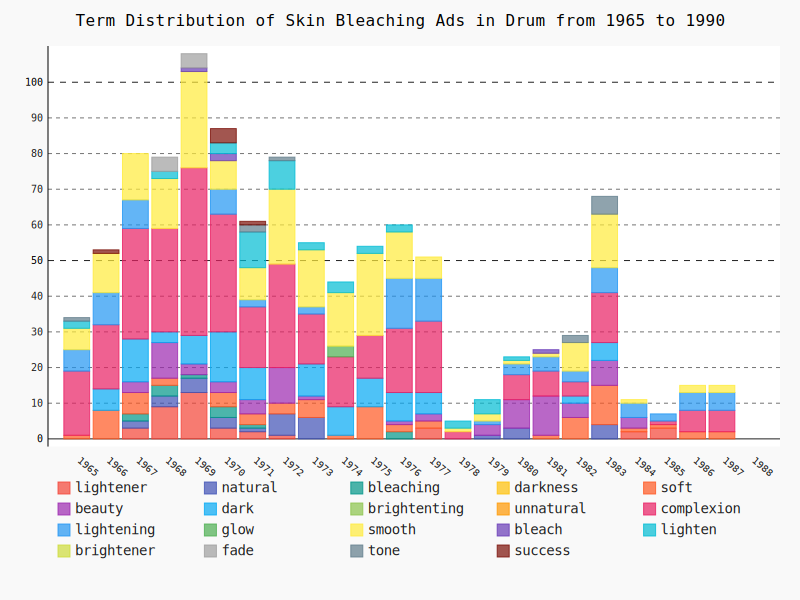

In [27]:
line_chart = pygal.StackedBar(x_label_rotation=40, legend_at_bottom=True)
line_chart.title = 'Term Distribution of Skin Bleaching Ads in Drum from 1965 to 1990'
line_chart.x_labels = map(str, range(1965, 1989))
for term in terms:
    line_chart.add(term, drum_term_counts[term])
display(SVG(line_chart.render(disable_xml_declaration=True))) 
line_chart.render_to_file("drum_term_counts_by_year.svg")

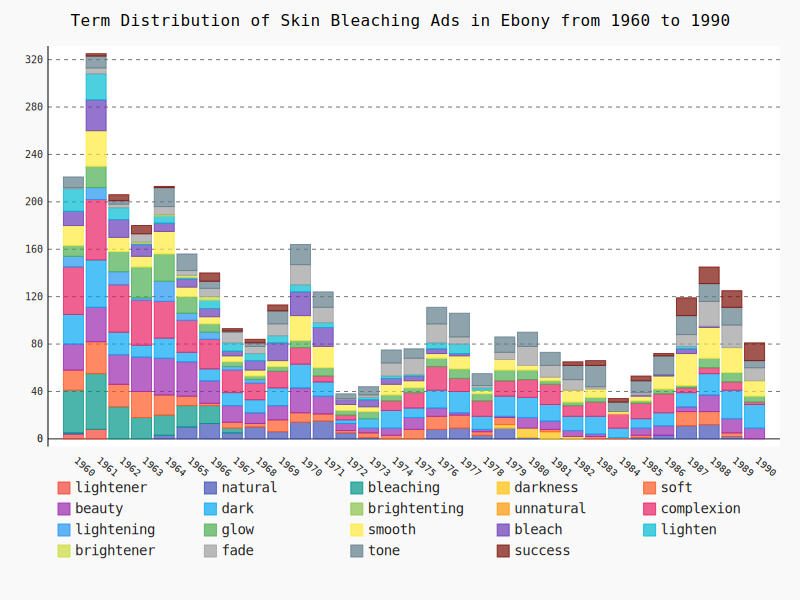

In [29]:
line_chart = pygal.StackedBar(x_label_rotation=40, legend_at_bottom=True)
line_chart.title = 'Term Distribution of Skin Bleaching Ads in Ebony from 1960 to 1990'
line_chart.x_labels = map(str, range(1960, 1991))
for term in terms:
    line_chart.add(term, ebony_term_counts[term])
display(SVG(line_chart.render(disable_xml_declaration=True))) 
line_chart.render_to_file("ebony_term_counts_by_year.svg")

In [30]:
drum_counts = []
ebony_counts = []
for year in years_ebony:
    e = 0
    for y,c in claims_ebony_sents:
        if str(year) == y[:4]:
            e += 1
    ebony_counts.append(e)
    d = 0
    for y,c in claims_drum_sents:
        if str(year) == y[:4]:
            d += 1
    drum_counts.append(d)
print(ebony_counts)
print(drum_counts)

[72, 103, 74, 82, 72, 58, 54, 36, 31, 34, 35, 24, 10, 9, 15, 22, 35, 39, 28, 31, 29, 32, 20, 24, 14, 20, 23, 34, 42, 41, 31]
[0, 0, 0, 0, 0, 46, 62, 93, 108, 132, 134, 96, 80, 99, 60, 82, 65, 68, 6, 12, 22, 28, 25, 57, 15, 7, 10, 17, 0, 0, 0]


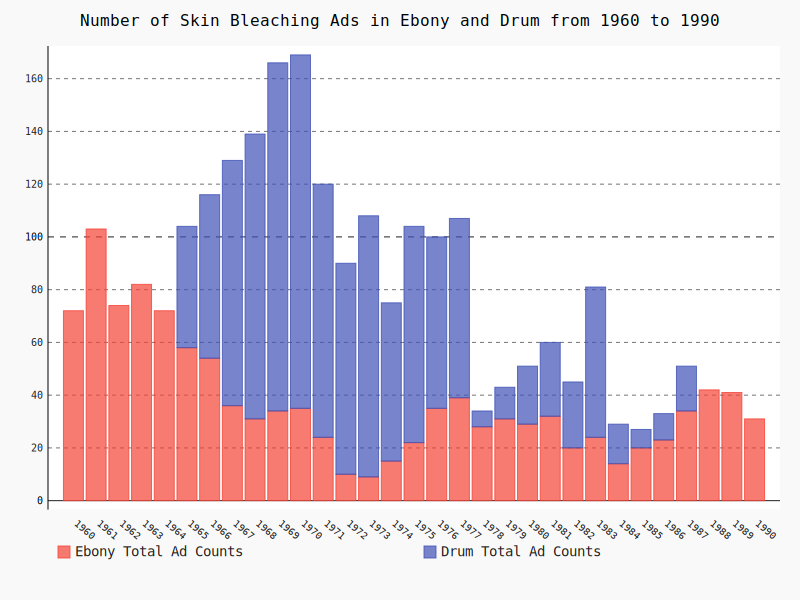

In [31]:
line_chart = pygal.StackedBar(x_label_rotation=40, legend_at_bottom=True)
line_chart.title = 'Number of Skin Bleaching Ads in Ebony and Drum from 1960 to 1990'
line_chart.x_labels = map(str, range(1960, 1991))
line_chart.add("Ebony Total Ad Counts", ebony_counts)
line_chart.add("Drum Total Ad Counts", drum_counts)
display(SVG(line_chart.render(disable_xml_declaration=True))) 
line_chart.render_to_file("drum_and_ebony_ad_counts_by_year.svg")

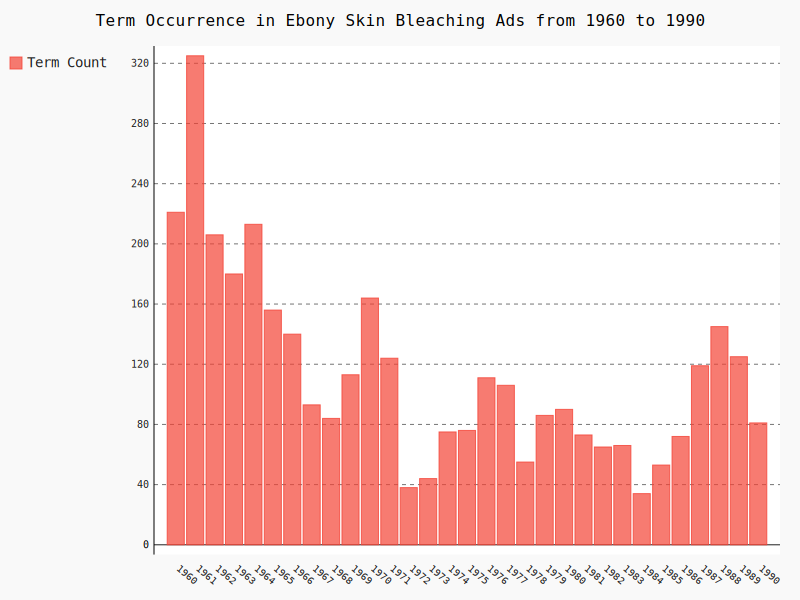

In [32]:
line_chart = pygal.StackedBar(x_label_rotation=40)
line_chart.title = 'Term Occurrence in Ebony Skin Bleaching Ads from 1960 to 1990'
line_chart.x_labels = map(str, range(1960, 1991))
ebony_year_list = []
for year in years_ebony:
    i = 0
    for y,c in claims_ebony_sents:
        if str(year) == y[:4]:
            for term in terms:
                if term in c.split():
                    i += 1
    ebony_year_list.append(i)
line_chart.add("Term Count", ebony_year_list)
display(SVG(line_chart.render(disable_xml_declaration=True))) 
line_chart.render_to_file("ebony_term_occurrence_by_year.svg")

In [33]:
claims_drum = claims_drum.dropna()
#claims_drum.replace(',','',regex = True) 

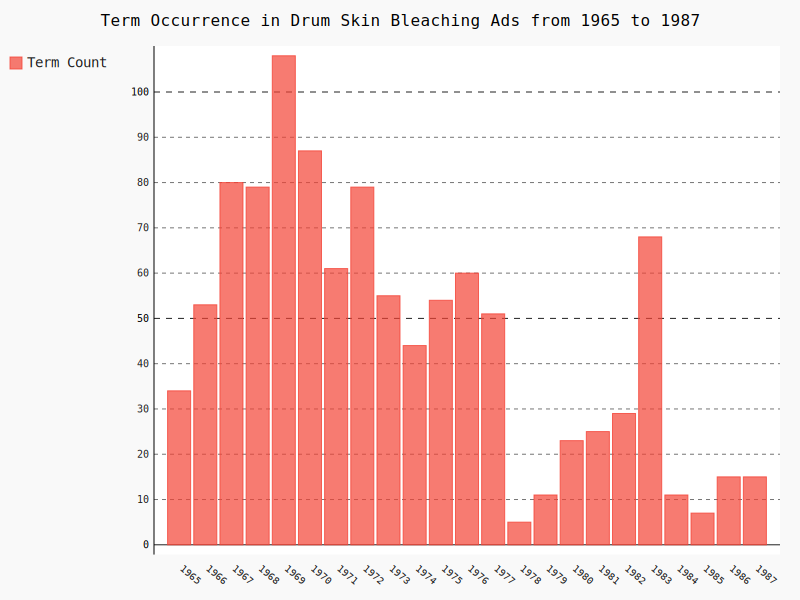

In [34]:
line_chart = pygal.StackedBar(x_label_rotation=40)
line_chart.title = 'Term Occurrence in Drum Skin Bleaching Ads from 1965 to 1987'
line_chart.x_labels = map(str, range(1965, 1988))
drum_year_list = []
for year in years_drum:
    i = 0
    for y,c in claims_drum_sents:
        if str(year) == y[:4]:
            for term in terms:
                if term in c.split():
                    i += 1
    drum_year_list.append(i)
line_chart.add("Term Count", drum_year_list)
display(SVG(line_chart.render(disable_xml_declaration=True))) 
line_chart.render_to_file("drum_term_occurrence_by_year.svg")

In [35]:
fill = [None for n in range(0,5)]

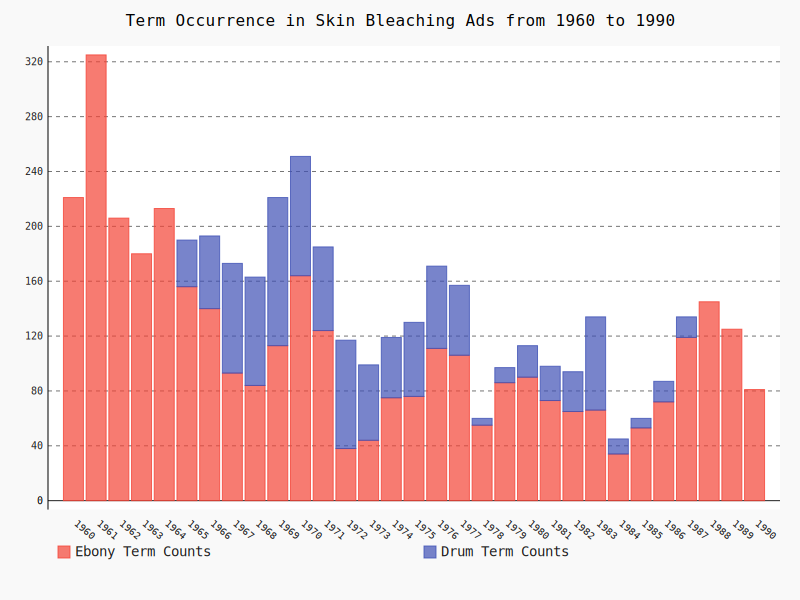

In [36]:
line_chart = pygal.StackedBar(x_label_rotation=40, legend_at_bottom=True)
line_chart.title = 'Term Occurrence in Skin Bleaching Ads from 1960 to 1990'
line_chart.x_labels = map(str, range(1960, 1991))
line_chart.add("Ebony Term Counts", ebony_year_list)
line_chart.add("Drum Term Counts", fill+drum_year_list)
display(SVG(line_chart.render(disable_xml_declaration=True))) 
line_chart.render_to_file("drum_and_ebony_term_occurrence_by_year.svg")

In [37]:
def add(list_counts):
    total = 0
    for i in list_counts:
        total += i
    return total

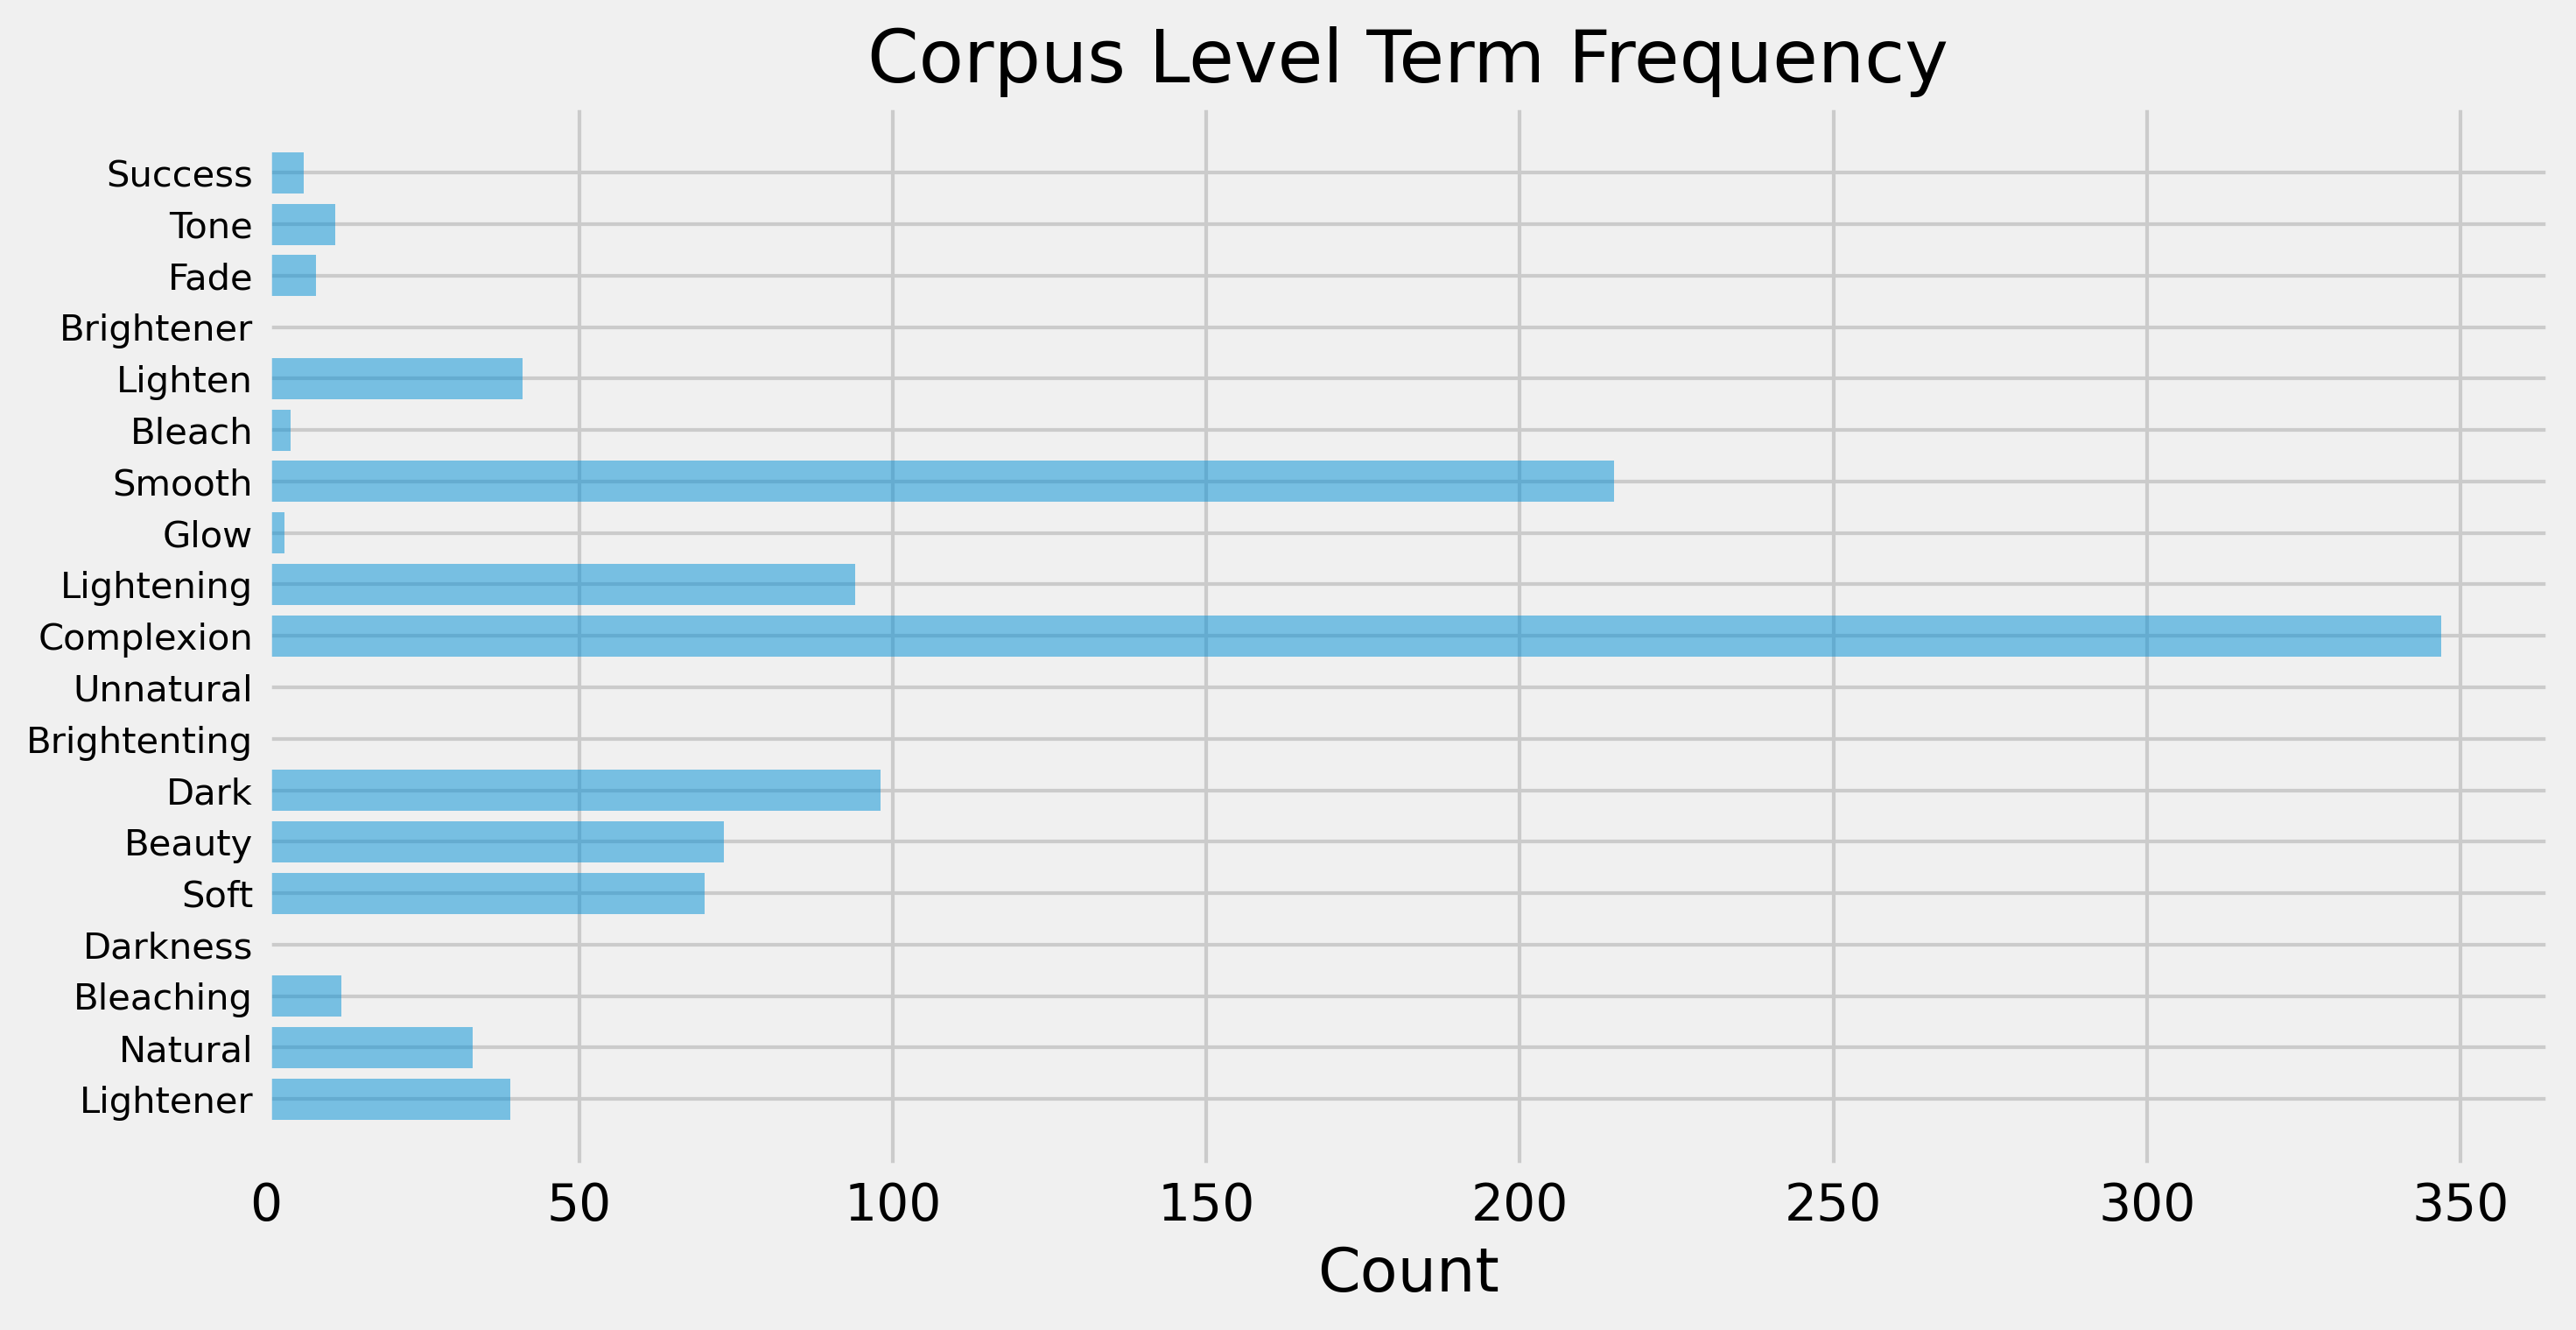

In [38]:
successfig = plt.figure(figsize=(10, 5), dpi=300)
objects = tuple([term.capitalize() for term in terms])
corpus_counts = dict(ebony_term_counts, **drum_term_counts)
termS1 = [add(count) for word,count in corpus_counts.items() if word in terms]
y_pos = np.arange(len(termS1))

plt.barh(y_pos, termS1, align='center', alpha=.5)
plt.yticks(y_pos, objects, fontsize = 10)
plt.xlabel('Count')
plt.title('Corpus Level Term Frequency')
 
plt.show()
successfig.savefig("corpus_freqs.png")

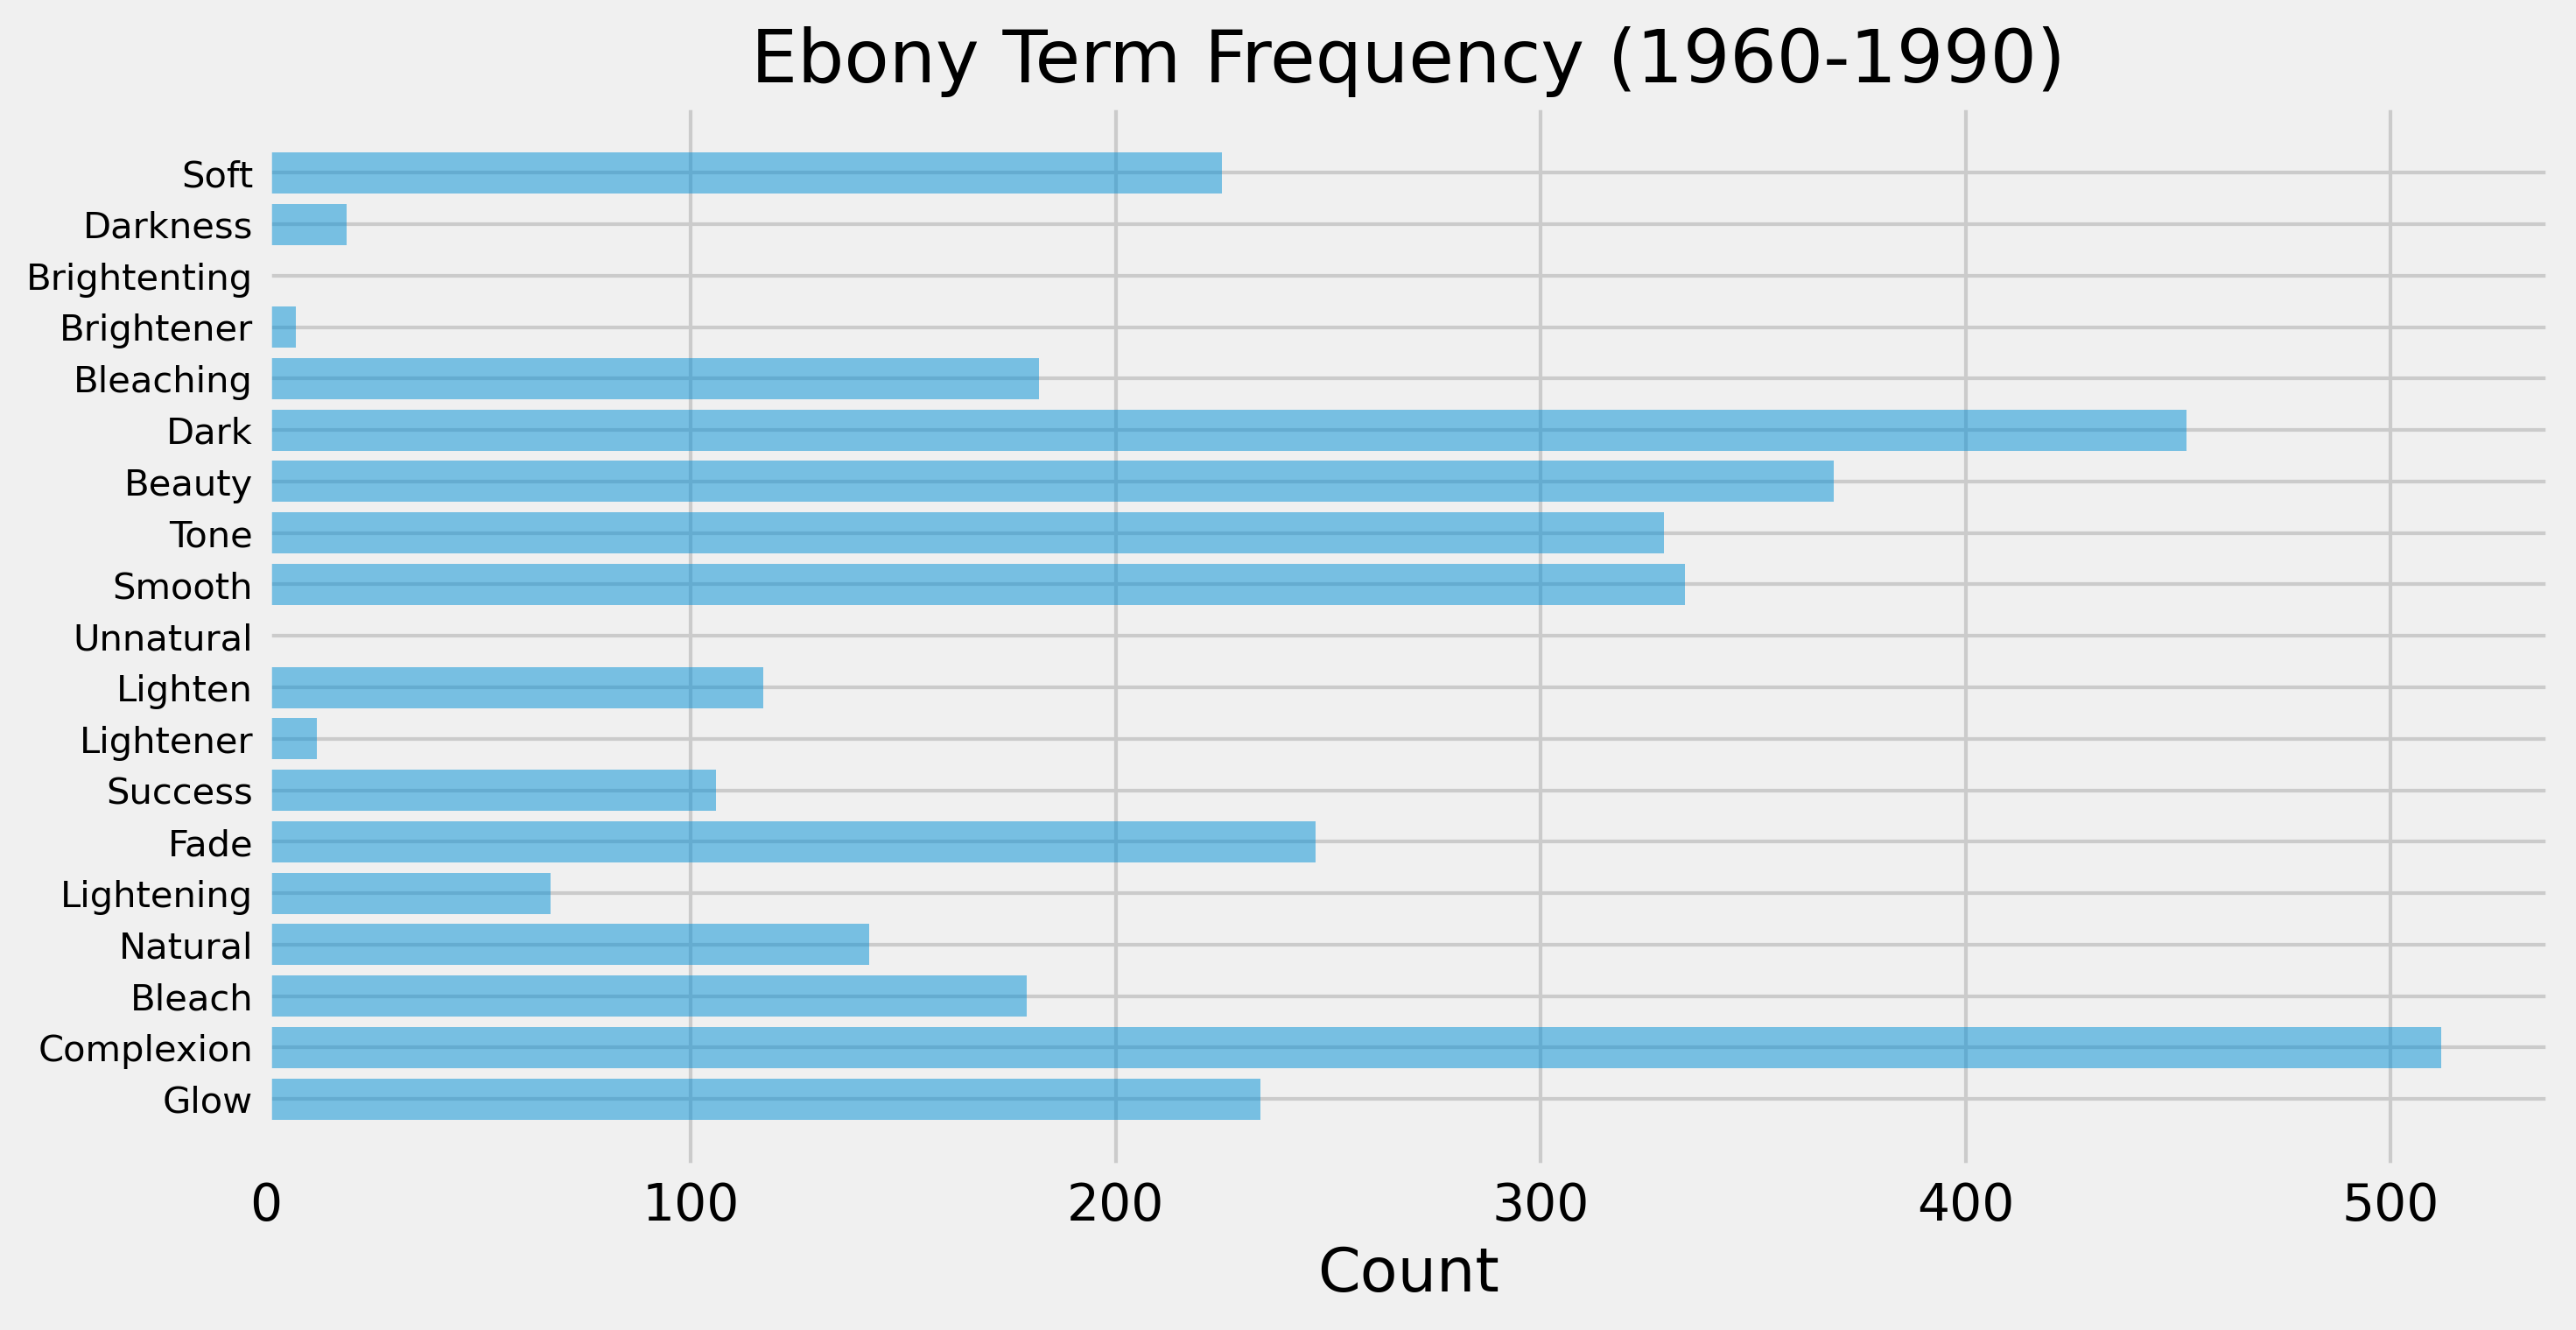

In [35]:
successfig = plt.figure(figsize=(10, 5), dpi=300)
objects = tuple([term.capitalize() for term in terms])
termS1 = [add(count) for word,count in ebony_term_counts.items() if word in terms]
y_pos = np.arange(len(termS1))

plt.barh(y_pos, termS1, align='center', alpha=.5)
plt.yticks(y_pos, objects, fontsize = 10)
plt.xlabel('Count')
plt.title('Ebony Term Frequency (1960-1990)')
 
plt.show()
successfig.savefig("ebony_freqs.png")

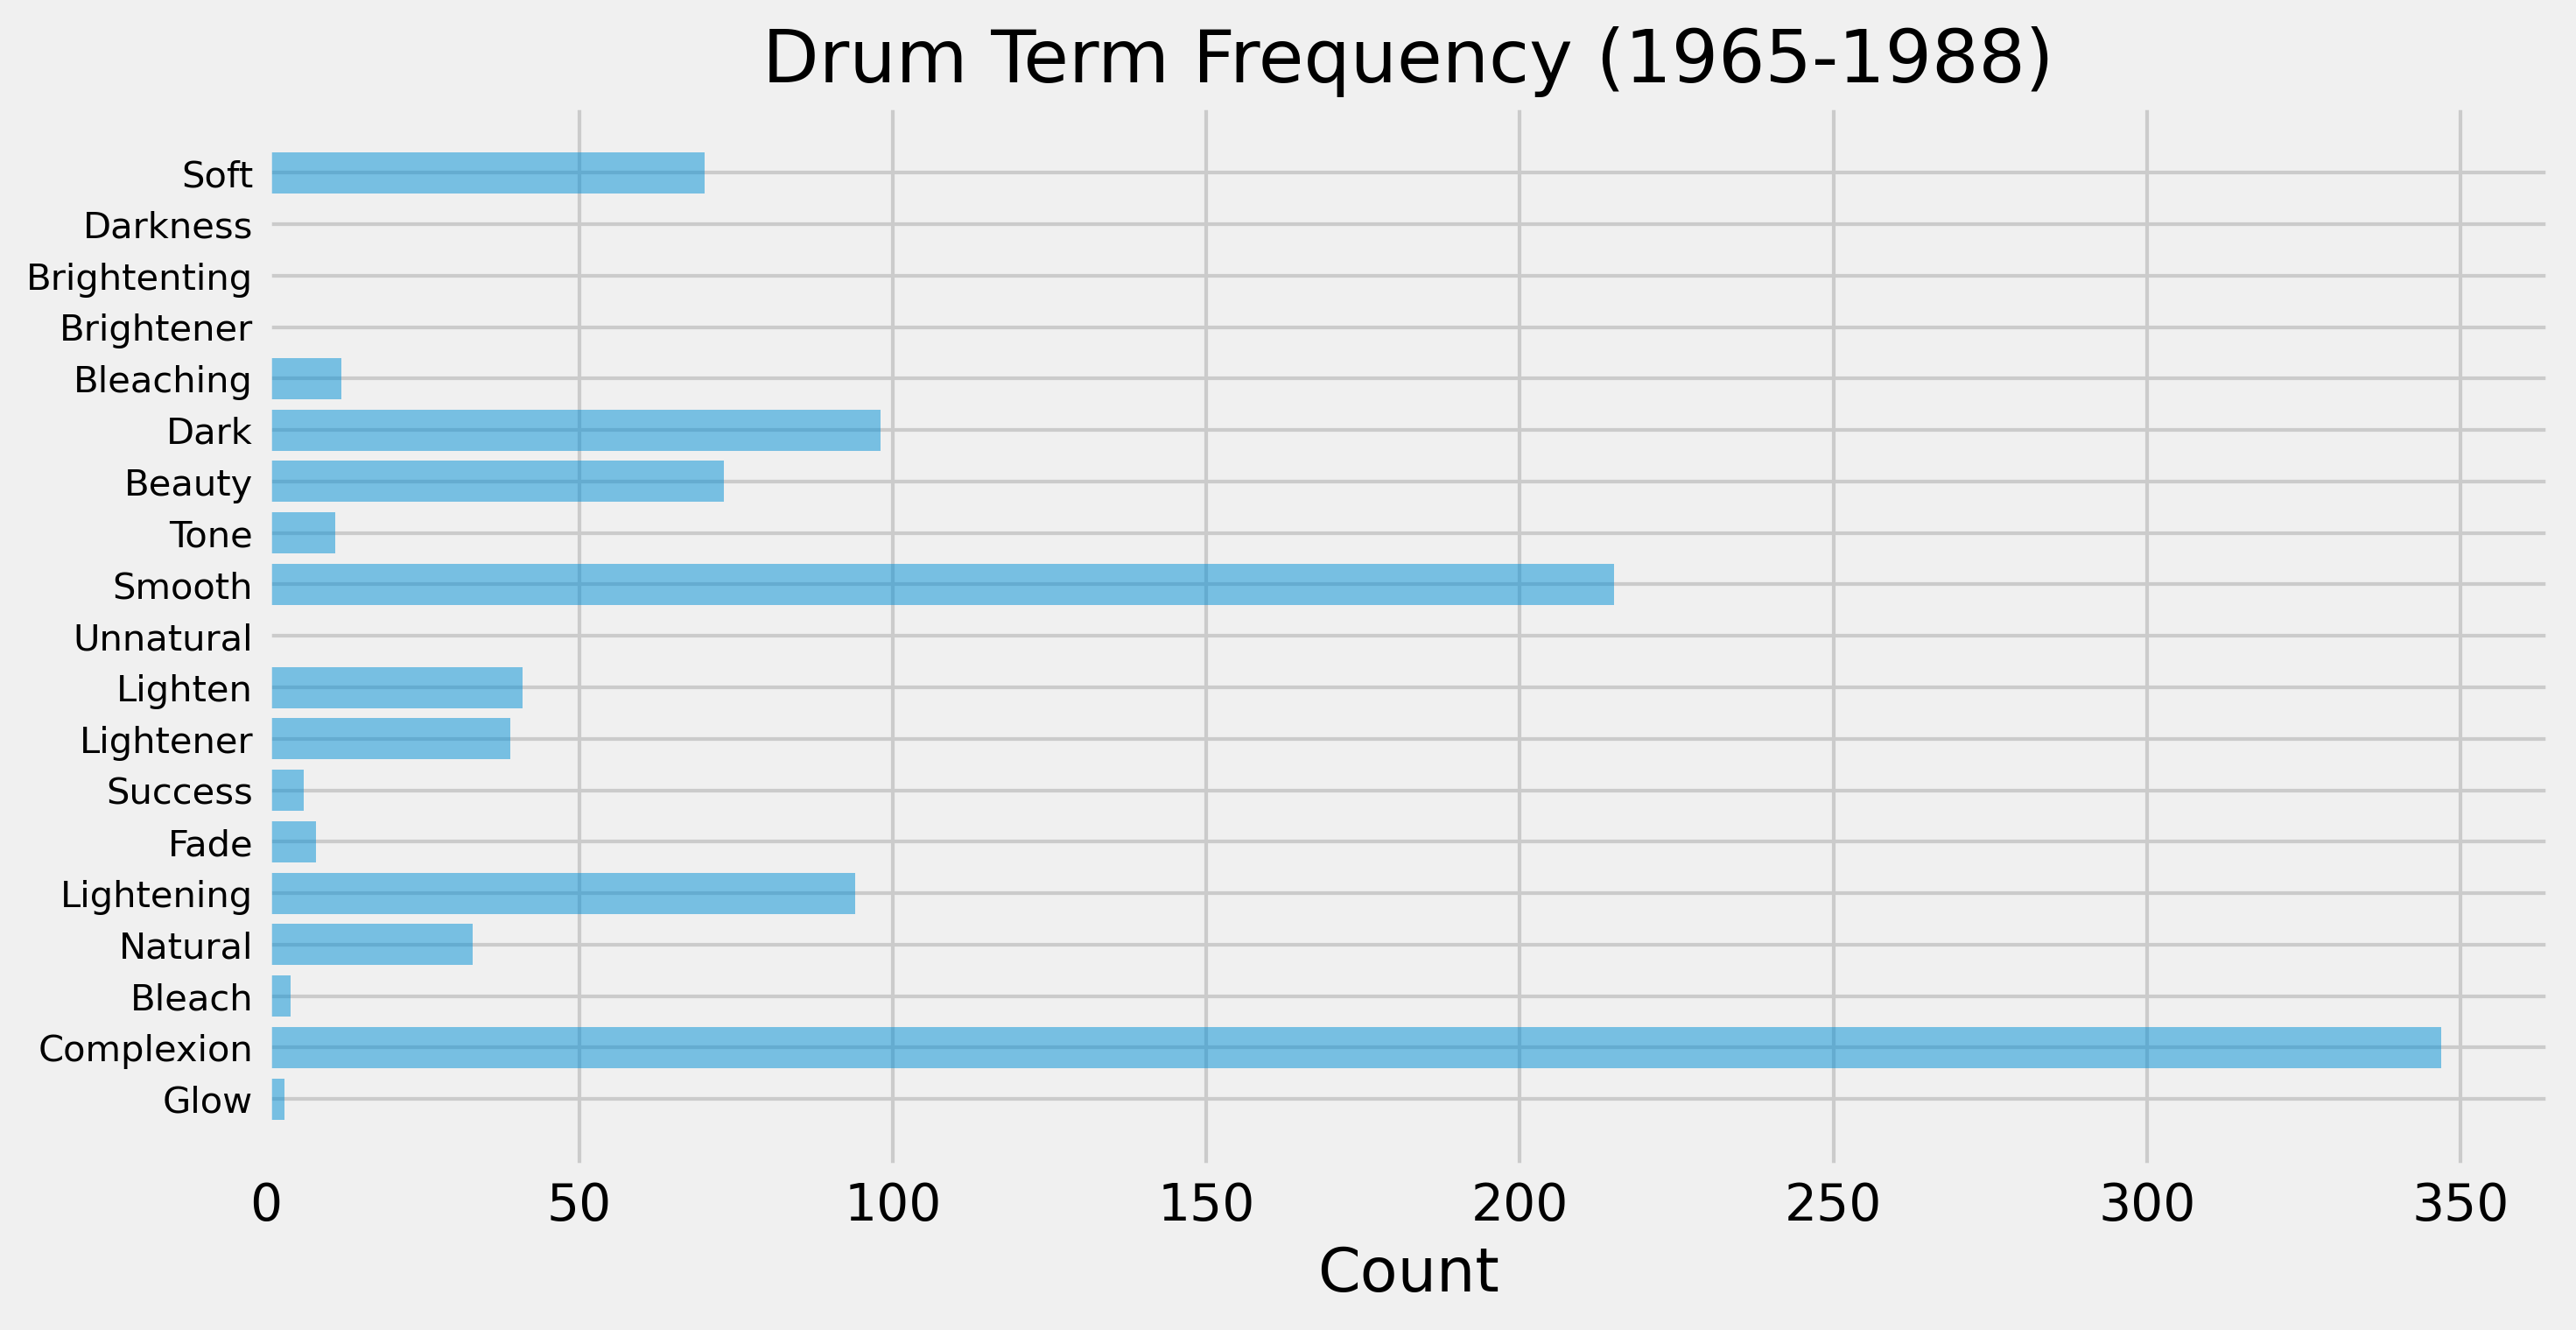

In [36]:
successfig = plt.figure(figsize=(10, 5), dpi=300)
objects = tuple([term.capitalize() for term in terms])
termS1 = [add(count) for word,count in drum_term_counts.items() if word in terms]
y_pos = np.arange(len(termS1))

plt.barh(y_pos, termS1, align='center', alpha=.5)
plt.yticks(y_pos, objects, fontsize = 10)
plt.xlabel('Count')
plt.title('Drum Term Frequency (1965-1988)')
 
plt.show()
successfig.savefig("drum_freqs.png")

<Figure size 120000x75000 with 0 Axes>

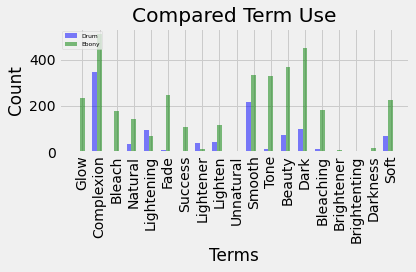

In [37]:
# data to plot
n_groups = len(objects)
fig = plt.figure(figsize=(400, 250), dpi=300)
# create plot
fig, ax = plt.subplots()
index = np.arange(n_groups)
bar_width = 0.28
opacity = 0.5

 
rects1 = plt.bar(index, [add(count) for word,count in drum_term_counts.items() if word in terms], bar_width,
                 alpha=opacity,
                 color='b',
                 label='Drum')
 
rects2 = plt.bar(index + bar_width, [add(count) for word,count in ebony_term_counts.items() if word in terms], bar_width,
                 alpha=opacity,
                 color='g',
                 label='Ebony')
 
plt.xlabel('Terms')
plt.ylabel('Count')
plt.title('Compared Term Use')
plt.xticks(index + bar_width, objects)
plt.xticks(rotation=90)
plt.legend(loc=2, prop={'size': 6})
 
plt.tight_layout()
plt.show()
fig.savefig("compared_term_use.png")

# Drum Magazine Topic Model

In [43]:
drum_claims_phrase = []
for c, p in drum_claims_phrase_list:
    cp = str(c) + str(p)
    drum_claims_phrase.append(cp)

In [44]:
lemma = WordNetLemmatizer()

In [45]:
exclude = set(string.punctuation)

In [140]:
stop = set(stopwords.words('english'))

In [53]:
def preprocess(doc):
    remove_stops=" ".join([i for i in doc.lower().split() if i not in stop])
    remove_punct="".join(character for character in remove_stops if character not in exclude)
    normalized=" ".join(lemma.lemmatize(word) for word in remove_punct.split())
    return normalized

In [54]:
cleaned_doc = [preprocess(doc).split() for doc in drum_claims_phrase]

In [55]:
dictionary = corpora.Dictionary(cleaned_doc)

In [56]:
doc_term_matrix = [dictionary.doc2bow(doc) for doc in cleaned_doc]

In [57]:
lda = gensim.models.ldamodel.LdaModel

In [58]:
ldamodel = lda(doc_term_matrix, num_topics=10, id2word = dictionary, passes=20)

In [59]:
drum_topics = ldamodel.print_topics(num_topics=10, num_words=5)
print(drum_topics)

[(0, '0.145*"extra" + 0.062*"fast" + 0.047*"hollywood" + 0.040*"skin" + 0.039*"seven"'), (1, '0.046*"new" + 0.042*"bright" + 0.035*"complexion" + 0.033*"free" + 0.032*"skin"'), (2, '0.115*"night" + 0.094*"karroo" + 0.076*"make" + 0.058*"lovely" + 0.054*"clearer"'), (3, '0.069*"skin" + 0.052*"looking" + 0.052*"lightens" + 0.041*"day" + 0.035*"pimple"'), (4, '0.089*"skin" + 0.088*"healthy" + 0.048*"clean" + 0.043*"beautiful" + 0.042*"natural"'), (5, '0.152*"skin" + 0.071*"beautiful" + 0.066*"keep" + 0.059*"light" + 0.043*"smooth"'), (6, '0.069*"skin" + 0.038*"beauty" + 0.037*"treatment" + 0.036*"complexion" + 0.036*"work"'), (7, '0.061*"ugly" + 0.060*"spot" + 0.058*"dark" + 0.052*"skin" + 0.049*"pimple"'), (8, '0.101*"skin" + 0.072*"lighter" + 0.040*"smoother" + 0.039*"lovelier" + 0.027*"look"'), (9, '0.138*"ambi" + 0.089*"skin" + 0.065*"people" + 0.058*"look" + 0.058*"use"')]


In [60]:
drum_topic_list=[]
for score,topic in drum_topics:
    topic_vals=[tuple(top.split("*")) for top in topic.split(" +")]
    drum_topic_list.append(topic_vals)

In [61]:
drum_topic_list

[[('0.145', '"extra"'),
  (' 0.062', '"fast"'),
  (' 0.047', '"hollywood"'),
  (' 0.040', '"skin"'),
  (' 0.039', '"seven"')],
 [('0.046', '"new"'),
  (' 0.042', '"bright"'),
  (' 0.035', '"complexion"'),
  (' 0.033', '"free"'),
  (' 0.032', '"skin"')],
 [('0.115', '"night"'),
  (' 0.094', '"karroo"'),
  (' 0.076', '"make"'),
  (' 0.058', '"lovely"'),
  (' 0.054', '"clearer"')],
 [('0.069', '"skin"'),
  (' 0.052', '"looking"'),
  (' 0.052', '"lightens"'),
  (' 0.041', '"day"'),
  (' 0.035', '"pimple"')],
 [('0.089', '"skin"'),
  (' 0.088', '"healthy"'),
  (' 0.048', '"clean"'),
  (' 0.043', '"beautiful"'),
  (' 0.042', '"natural"')],
 [('0.152', '"skin"'),
  (' 0.071', '"beautiful"'),
  (' 0.066', '"keep"'),
  (' 0.059', '"light"'),
  (' 0.043', '"smooth"')],
 [('0.069', '"skin"'),
  (' 0.038', '"beauty"'),
  (' 0.037', '"treatment"'),
  (' 0.036', '"complexion"'),
  (' 0.036', '"work"')],
 [('0.061', '"ugly"'),
  (' 0.060', '"spot"'),
  (' 0.058', '"dark"'),
  (' 0.052', '"skin"'),
  

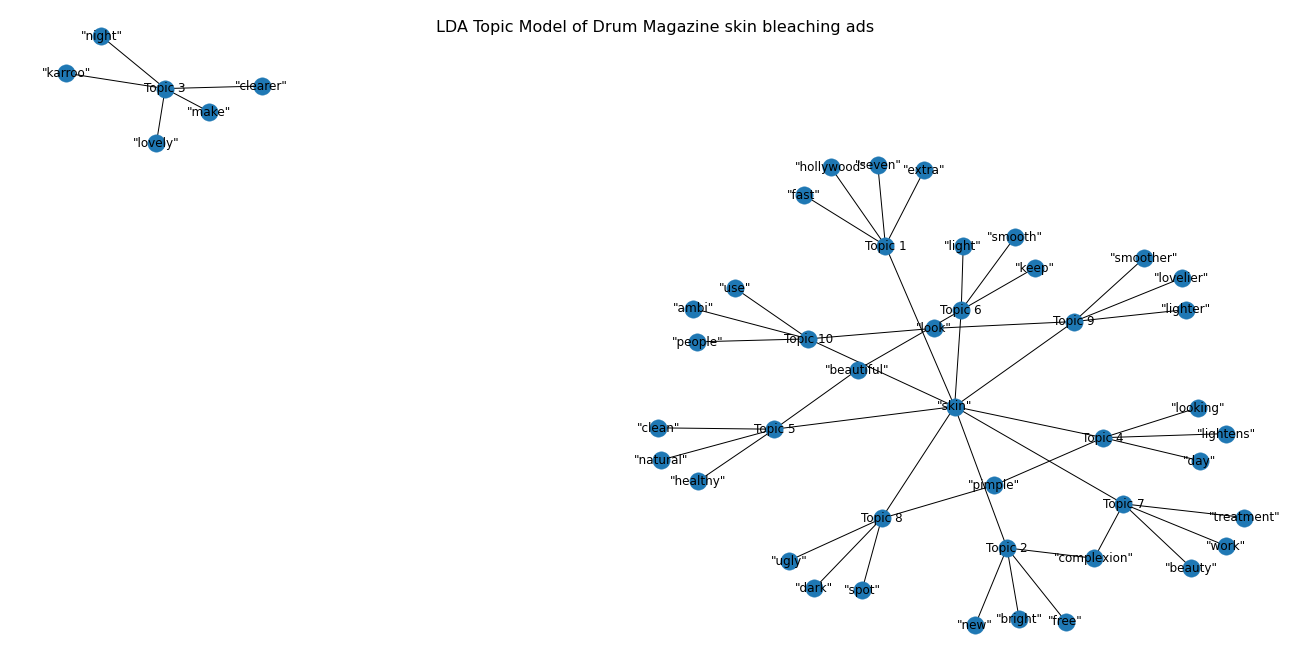

In [63]:
G = nx.Graph()
top_num = 0
for topics in drum_topic_list:
    top_num += 1
    G.add_node("Topic "+str(top_num))
    for topic in topics:
        G.add_node(topic[1])
        G.add_edge("Topic "+str(top_num), topic[1])
plt.figure(figsize=(18,9))
plt.suptitle("LDA Topic Model of Drum Magazine skin bleaching ads", fontsize=16)
nx.draw(G, with_labels=True)
plt.savefig("./drum_LDA_network.png")

# Ebony Topics

In [47]:
claims_ebony.head()

Year
1960-01-01    " - wakes up dark, dull complexion! Conceals u...
1960-01-01    "If your skin doesn't look actually lighter af...
1960-01-01    "And you, too, can have a glamorous complexion...
1960-01-01    "Don't let dull, dark skin rob you of romance....
1960-01-01    "Yes in just 7 days be delighted how fast and ...
Name: Claims, dtype: object

In [48]:
catch_phrase_ebony.head()

Year
1960-01-01    "Mercolized Wax Cream guarantees lighter looki...
1960-01-01             "Lighter, brighter skin is irresistable"
1960-01-01    "LIFE IS MORE FUN when your complexion is clea...
1960-01-01    "DR. FRED PALMER'S IN JUST 7 DAYS MUST GIVE YO...
1960-01-01    "Egyptian formula BLEACH CRÈME gives amazing r...
Name: Advertising strategy *quotes-catch phrase*, dtype: object

In [49]:
ebony_catch_phrase_and_claims = pd.merge(catch_phrase_ebony, claims_ebony, right_index=True, left_index=True)

In [50]:
ebony_claims_phrase_list = ebony_catch_phrase_and_claims.values.tolist()

In [52]:
ebony_claims_phrase_list[:10]

[['"Mercolized Wax Cream guarantees lighter looking skin in just 7 days or money back!"',
  '" - wakes up dark, dull complexion! Conceals ugly blotches, blemishes while it bleaches. Guarantees lovelier, lighter skin."'],
 ['"Mercolized Wax Cream guarantees lighter looking skin in just 7 days or money back!"',
  '"If your skin doesn\'t look actually lighter after using Mercolized Wax Cream for just one week, your money will be cheerfully refunded."; "You\'ll see amazing results almost at once - as Mercolized Wax Cream\'s speedy bleaching action lightens your complexion, fades dark blotches, spots, and freckles, brings excessive skin oiliness under control."; "...works under the skin surface to bring about these marvelous results."; "Used by beautiful women for over 40 years."'],
 ['"Mercolized Wax Cream guarantees lighter looking skin in just 7 days or money back!"',
  '"And you, too, can have a glamorous complexion!"; "…see your skin get a lighter, brighter, softer look."; "Its bleachi

In [ ]:
ebony_claims_phrase = []
for c, p in ebony_claims_phrase_list:
    cp = str(c) + str(p)
    ebony_claims_phrase.append(cp)

In [ ]:
ebony_cleaned_doc = [preprocess(doc).split() for doc in ebony_claims_phrase]

In [ ]:
dictionary = corpora.Dictionary(ebony_cleaned_doc)

In [ ]:
doc_term_matrix = [dictionary.doc2bow(doc) for doc in ebony_cleaned_doc]

In [ ]:
lda = gensim.models.ldamodel.LdaModel

In [ ]:
ldamodel = lda(doc_term_matrix, num_topics=10, id2word = dictionary, passes=20)

In [ ]:
ebony_topics = ldamodel.print_topics(num_topics=10, num_words=5)
print(ebony_topics)

In [ ]:
ebony_topic_list=[]
for score,topic in ebony_topics:
    topic_vals=[tuple(top.split("*")) for top in topic.split(" +")]
    ebony_topic_list.append(topic_vals)

In [ ]:
ebony_topic_list

In [ ]:
G = nx.Graph()
top_num = 0
for topics in ebony_topic_list:
    top_num += 1
    G.add_node("Topic "+str(top_num))
    for topic in topics:
        G.add_node(topic[1])
        G.add_edge("Topic "+str(top_num), topic[1])
plt.figure(figsize=(18,9))
plt.suptitle("LDA Topic Model of Ebony Magazine skin bleaching ads", fontsize=16)
nx.draw(G, with_labels=True)
plt.savefig("./ebony_LDA_network.png")

# Drum and Ebony Topics

In [ ]:
both_catch_phrase_and_claims = pd.merge(drum_catch_phrase_and_claims, ebony_catch_phrase_and_claims, right_index=True, left_index=True)

In [ ]:
both_claims_phrase_list = both_catch_phrase_and_claims.values.tolist()

In [ ]:
both_claims_phrase_list[:10]

In [ ]:
both_claims_phrase = []
for c1, p1, c2, p2 in both_claims_phrase_list:
    cp = str(c1) + str(p1) + str(c2) + str(p2)
    both_claims_phrase.append(cp)

In [ ]:
cleaned_doc = [preprocess(doc).split() for doc in both_claims_phrase]

In [ ]:
dictionary = corpora.Dictionary(cleaned_doc)

In [ ]:
doc_term_matrix = [dictionary.doc2bow(doc) for doc in cleaned_doc]

In [ ]:
lda = gensim.models.ldamodel.LdaModel

In [ ]:
ldamodel = lda(doc_term_matrix, num_topics=10, id2word = dictionary, passes=20)

In [ ]:
both_topics = ldamodel.print_topics(num_topics=10, num_words=5)
print(both_topics)

In [ ]:
both_topic_list=[]
for score,topic in both_topics:
    topic_vals=[tuple(top.split("*")) for top in topic.split(" +")]
    both_topic_list.append(topic_vals)

In [ ]:
both_topic_list

In [ ]:
G = nx.Graph()
top_num = 0
for topics in both_topic_list:
    top_num += 1
    G.add_node("Topic "+str(top_num))
    for topic in topics:
        G.add_node(topic[1])
        G.add_edge("Topic "+str(top_num), topic[1])
plt.figure(figsize=(18,9))
plt.suptitle("LDA Topic Model of Drum and Ebony Magazine skin bleaching ads", fontsize=16)
nx.draw(G, with_labels=True)
plt.savefig("./drum_ebony_LDA_network.png")

# Word Vectors with t-SNE

In [ ]:
model = word2vec.Word2Vec(corpus, size=100, window=20, min_count=200, workers=4)